## Final Project - ECG Arrhythmia Detection


In [2]:
!pip install -q wfdb matplotlib pandas numpy scipy scikit-learn kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 124.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
!rm -r '/content/kaggle'
import os
os.makedirs('/content/kaggle')

credentials_data = {
"username": "mariaamm",
"key": ""
}
import json
json_path = '/content/kaggle/kaggle.json'
with open(json_path, 'w') as f:
  json.dump(credentials_data, f, indent=2)

!pip install -q kaggle

os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle'
!kaggle datasets download -d mariaamm/mit-bih-arrhythmia-database-1-0-0

rm: cannot remove '/content/kaggle': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mariaamm/mit-bih-arrhythmia-database-1-0-0
License(s): CC0-1.0
  0% 0.00/73.4M [00:00<?, ?B/s]
100% 73.4M/73.4M [00:00<00:00, 841MB/s]


Load the Records

In [4]:
import zipfile
import os

zip_filename = '/content/mit-bih-arrhythmia-database-1-0-0.zip'

# Extract the ZIP file
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Target directorY

 # Dataset Exploration and Visualization
 Download the dataset (full ZIP archive) from the official source.



---


*   Unzip the downloaded file and locate the records 100, 101, and 102
*   Load each record using the wfdb Python library:(each record consists of a .dat, .hea, and .atr file).
* Read the ECG signals.
- Extract metadata like sampling frequency, channel names, and recording duration.
* Plot a 10-second segment from one channel (e.g., MLII) of the ECG signal:
* Convert sample indices to time in seconds.
* Label axes clearly (Time [s], Amplitude [mV]).
* Load and overlay heartbeat annotations:
* Extract annotation symbols and their corresponding sample locations.
* Superimpose these annotations on the ECG plot using colored markers.
* Include a legend indicating the meaning of each annotation symbol.
* Summarize the distribution of different heartbeat types present in the visualized segment.


=== Processing Record 100 ===
Sampling frequency: 360 Hz
Channels: ['MLII', 'V5']
Duration: 1805.56 seconds


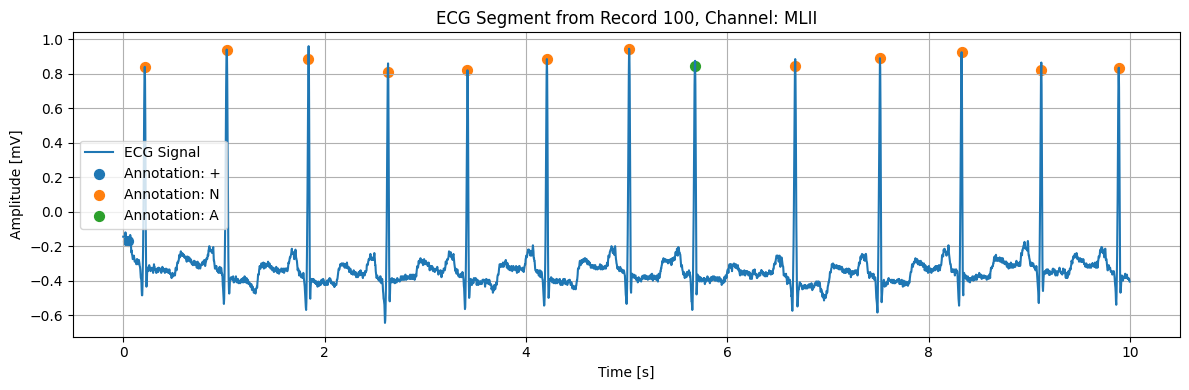

Heartbeat Type Distribution in 10-Second Segment:
+: 1
N: 12
A: 1

=== Processing Record 101 ===
Sampling frequency: 360 Hz
Channels: ['MLII', 'V1']
Duration: 1805.56 seconds


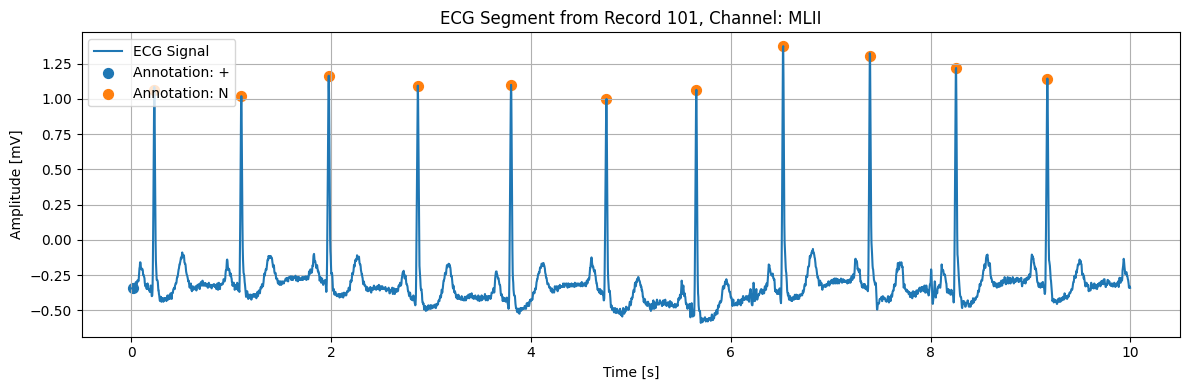

Heartbeat Type Distribution in 10-Second Segment:
+: 1
N: 11

=== Processing Record 102 ===
Sampling frequency: 360 Hz
Channels: ['V5', 'V2']
Duration: 1805.56 seconds


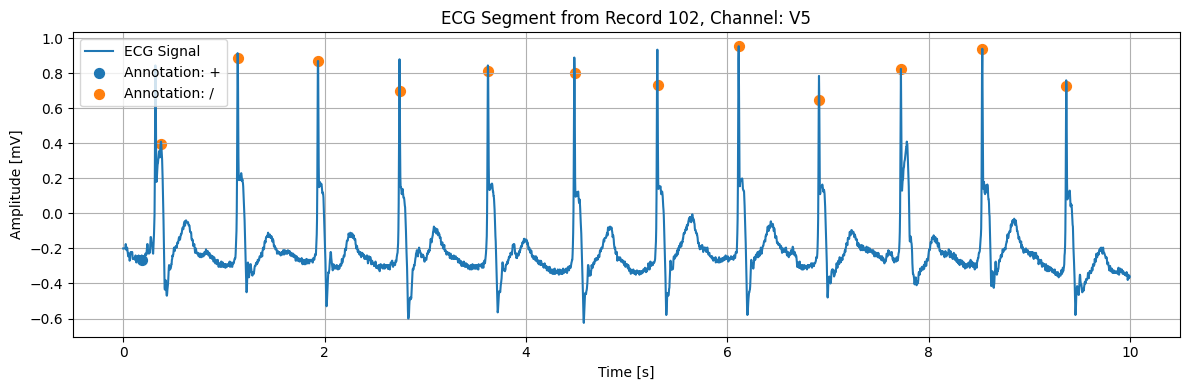

Heartbeat Type Distribution in 10-Second Segment:
+: 1
/: 12
Total Heartbeat Type Distribution present in selected records:
beat_type
/    2028
N      99
f      56
+       5
V       4
Name: count, dtype: int64


In [5]:
import wfdb
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
# List of record names
record_names = ['100', '101', '102']

for record_name in record_names:
    print(f"\n=== Processing Record {record_name} ===")
    record_path = f'mit-bih-arrhythmia-database-1.0.0/{record_name}'
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')

    # Update stats
    symbols, cnts = np.unique(annotation.symbol, return_counts=True)
    beat_types = []
    beat_cnts = []
    beat_types.extend(symbols)
    beat_cnts.extend(cnts)

    # Metadata
    fs = record.fs
    channels = record.sig_name
    duration_sec = len(record.p_signal) / fs
    print(f"Sampling frequency: {fs} Hz")
    print(f"Channels: {channels}")
    print(f"Duration: {duration_sec:.2f} seconds")

    # Choose channel MLII if present
    channel_name = 'MLII' if 'MLII' in channels else channels[0]
    channel_index = channels.index(channel_name)

    # 10-second segment
    start_time = 0
    end_time = 10
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)

    # Extract signal
    signal_segment = record.p_signal[start_sample:end_sample, channel_index]
    time_segment = np.arange(start_sample, end_sample) / fs

    # Plot ECG segment
    plt.figure(figsize=(12, 4))
    plt.plot(time_segment, signal_segment, label='ECG Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [mV]')
    plt.title(f"ECG Segment from Record {record_name}, Channel: {channel_name}")

    # Overlay annotations within the segment
    ann_samples = annotation.sample
    ann_symbols = annotation.symbol
    segment_ann_indices = np.where((ann_samples >= start_sample) & (ann_samples < end_sample))[0]
    segment_ann_samples = ann_samples[segment_ann_indices]
    segment_ann_symbols = [ann_symbols[i] for i in segment_ann_indices]
    segment_ann_times = np.array(segment_ann_samples) / fs
    segment_ann_amps = record.p_signal[segment_ann_samples, channel_index]

    # Plot annotations
    for symbol in set(segment_ann_symbols):
        sym_times = [segment_ann_times[i] for i in range(len(segment_ann_symbols)) if segment_ann_symbols[i] == symbol]
        sym_amps = [segment_ann_amps[i] for i in range(len(segment_ann_symbols)) if segment_ann_symbols[i] == symbol]
        plt.scatter(sym_times, sym_amps, label=f"Annotation: {symbol}", s=50, marker='o')

    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Count and display heartbeat type distribution in segment
    symbol_counts = Counter(segment_ann_symbols)
    print("Heartbeat Type Distribution in 10-Second Segment:")
    for sym, count in symbol_counts.items():
        print(f"{sym}: {count}")

# Print the stats
df_beats = pd.DataFrame({'beat_type':beat_types, 'count':beat_cnts})
print("Total Heartbeat Type Distribution present in selected records:")
print(df_beats.groupby('beat_type')['count'].sum().sort_values(ascending=False))

2. Signal Preprocessing and Noise Removal
---
This section focuses on improving the quality of the raw ECG signal through several
preprocessing techniques. These steps help remove various types of noise and artifacts that
commonly affect ECG recordings, allowing for more accurate downstream analysis such as
peak detection and classification. It is required to implemet:


1.   Baseline Wander Removal:
Low-frequency noise, typically due to patient movement or respiration, is removed by
applying a high-pass filter that attenuates frequencies below 0.5 Hz.
2.   Power Line Interference Removal:
ECG signals often contain 50 Hz (or 60 Hz depending on region) interference from
electrical power sources. A notch filter is designed to suppress this interference without
affecting the rest of the signal.
3. Noise Reduction and Smoothing:
General high-frequency noise is suppressed using a low-pass filter or a band-pass filter,
preserving relevant signal components while improving signal-to-noise ratio.

---
Note: Each filtering step is visualized to compare the original and the cleaned signal.
Requirements:
* Implement baseline wander removal using Fourier Transform.
* Implement a notch filter to eliminate 50 Hz powerline interference.
* Apply smoothing or bandpass filtering to reduce high-frequency noise while preserving
ECG morphology.
* Plot and compare the signal before and after each preprocessing step.
* Comment on the observed differences in signal shape and quality.


In [6]:
from scipy.signal import iirnotch, filtfilt, butter
from IPython.display import Image, display

# === Parameters ===
records = ['100', '101', '102']

In [7]:
# === Filtering Functions ===
def remove_baseline_wander_fft(signal, fs, cutoff=0.5):
    N = len(signal)
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, d=1/fs)
    fft_signal[np.abs(freqs) < cutoff] = 0
    return np.real(np.fft.ifft(fft_signal))

In [8]:
def apply_notch_filter(signal, fs, notch_freq=50.0, quality=30):
    b, a = iirnotch(notch_freq/(fs/2), Q=quality)
    return filtfilt(b, a, signal)

In [9]:
def bandpass_filter(signal, fs, lowcut=0.5, highcut=40, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

In [10]:
duration_sec = 1
notch_freq = 50.0
band_low = 0.5
band_high = 40

Processing record 100...
Processing record 101...
Processing record 102...


<Figure size 1500x1000 with 0 Axes>

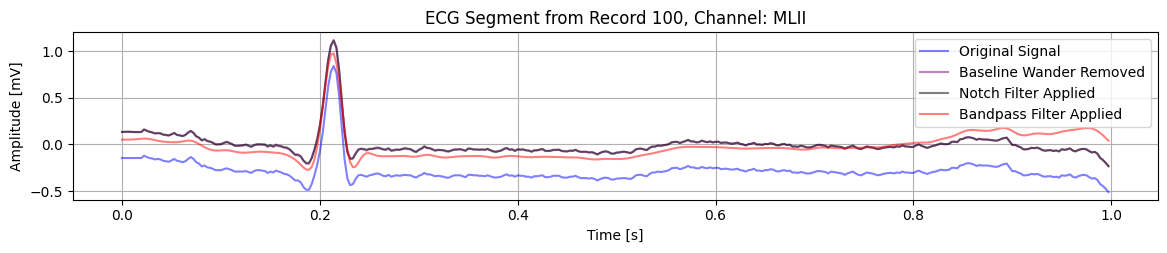

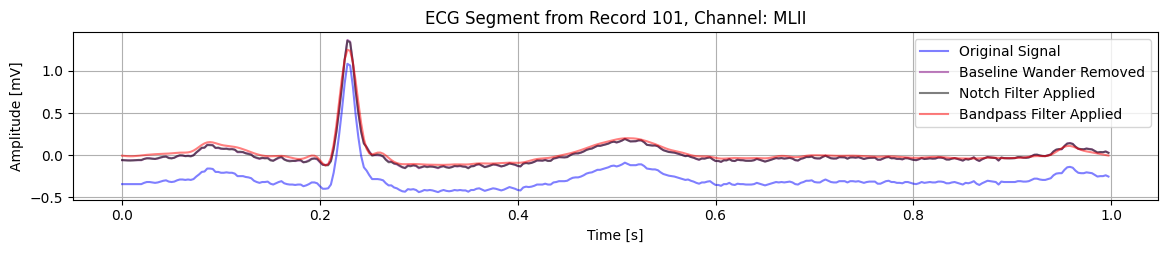

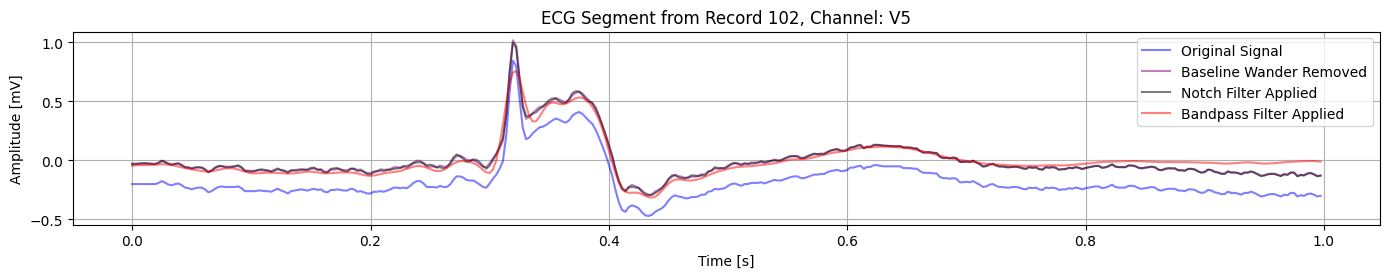

 All records processed, displayed, and downloaded.


In [11]:
plt.figure(figsize=(15, 10))

# === Loop Through Each Record ===
for record_name in records:

    print(f"Processing record {record_name}...")
    record_path = f'mit-bih-arrhythmia-database-1.0.0/{record_name}'
    record = wfdb.rdrecord(record_path)

    start_sample = 0
    end_sample = int(duration_sec * fs)

    ecg_raw = record.p_signal[start_sample:end_sample, channel_index]

    fs = record.fs
    channels = record.sig_name
    channel_name = 'MLII' if 'MLII' in channels else channels[0]
    channel_index = channels.index(channel_name)

    ecg_full_duration = len(record.p_signal) / fs
    ecg_raw = record.p_signal[start_sample:end_sample, channel_index]
    # t = np.arange(start_sample, len(record.p_signal[:,channel_index])) / fs
    t = np.arange(start_sample, end_sample) / fs

    # === Preprocessing Steps ===
    ecg_no_baseline = remove_baseline_wander_fft(ecg_raw, fs)
    ecg_no_notch = apply_notch_filter(ecg_no_baseline, fs, notch_freq)
    ecg_filtered = bandpass_filter(ecg_no_notch, fs, band_low, band_high)

    # # === Plotting ===
    plt.figure(figsize=(14, 10))

    ax = plt.subplot(4, 1, 1)
    plt.plot(t, ecg_raw, label=f'Original Signal', color='blue', alpha=0.5)
    plt.plot(t, ecg_no_baseline, label=f'Baseline Wander Removed', color='purple', alpha=0.5)
    plt.plot(t, ecg_no_notch, label=f'Notch Filter Applied', color='black', alpha=0.5)
    plt.plot(t, ecg_filtered, label=f'Bandpass Filter Applied', color='red', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title(f"ECG Segment from Record {record_name}, Channel: {channel_name}")
    plt.xlabel("Time [s]")
    plt.ylabel('Amplitude [mV]')
    plt.grid()

    # plt.subplot(4, 1, 2)
    # plt.plot(t, ecg_no_baseline, color='purple')
    # plt.title("After Baseline Wander Removal")
    # plt.xlabel("Time [s]")
    # plt.ylabel('Amplitude [mV]')
    # plt.grid()

    # plt.subplot(4, 1, 3)
    # plt.plot(t, ecg_no_notch, color='black')
    # plt.title("After 50Hz Notch Filter")
    # plt.xlabel("Time [s]")
    # plt.ylabel('Amplitude [mV]')
    # plt.grid()

    # plt.subplot(4, 1, 4)
    # plt.plot(t, ecg_filtered, color='red')
    # plt.title(" After Bandpass Filter")
    # plt.xlabel("Time [s]")
    # plt.ylabel('Amplitude [mV]')
    # plt.grid()

    # # ax = plt.subplot(3, 1, i + 1)
    # # ax.plot(time, segment, label=f'Original Signal', alpha=0.5)
    # # ax.plot(time, hpf_segment, label=f'Filtered Signal', alpha=0.5) # Plot the filtered segment
    # # ax.set_title(f"Record {rec} | Baseline Wander Removal")
    # # ax.set_xlabel("Time [s]")
    # # ax.set_ylabel("Amplitude [mV]")
    # # ax.legend(loc='upper right')
    # # ax.grid(True)


plt.tight_layout()
plt.show()

    # === Display in Colab ===

# === Save and Download CSV ===
    # df = pd.DataFrame({'Time (s)': t, 'Filtered ECG (mV)': ecg_filtered})
    # csv_path = f'/content/filtered_ecg_record_{record_name}.csv'
    # df.to_csv(csv_path, index=False)

    # # === Download CSV and PNG ===
    # files.download(csv_path)
    # files.download(plot_path)

print(" All records processed, displayed, and downloaded.")

## Comment
---
# Commentary on ECG Signal Changes After Filtering Stages

## Baseline Wander Removal (Fourier Transform Method)

When baseline wander is removed from the ECG signal using the Fourier Transform approach, several significant changes are observable:

- **Horizontal Stabilization**: The most noticeable change is that the signal now oscillates around a consistent baseline (typically zero). Before this filtering, the signal likely showed slow, wave-like vertical shifts that made it difficult to interpret ST segments and other isoelectric portions of the ECG.

- **Improved Amplitude Accuracy**: By removing the low-frequency components below 0.5 Hz, the relative heights of the various ECG waves (P, QRS, T) become more accurately represented, making amplitude measurements more reliable.

- **Enhanced Feature Detection**: With a stable baseline, it becomes much easier to detect the onset and offset of key ECG components, particularly the J-point and ST segment.

- **Preserved Morphology**: The high-frequency components of the ECG that represent the actual cardiac electrical activity remain intact, so the essential shape of the P, QRS, and T waves is preserved.

## Notch Filter (50 Hz Powerline Interference)

After applying the notch filter targeted at 50 Hz, the following changes can be observed:

- **Reduced Grid-Like Noise**: The characteristic high-frequency oscillations that create a "fuzzy" appearance to the signal (resembling the power grid frequency) are substantially reduced or eliminated.

- **Smoother Wave Contours**: The edges of the ECG waveforms appear cleaner and less jagged, particularly noticeable on steeper segments like the QRS complex.

- **Minimal Morphological Distortion**: A well-designed notch filter with appropriate Q factor (30 in your implementation) effectively removes the target frequency while minimizing distortion of the surrounding frequencies, preserving important ECG features.

- **Improved Signal-to-Noise Ratio**: The removal of this consistent noise source makes the actual cardiac signal components more prominent.

## Bandpass Filtering (0.5-40 Hz)

The final bandpass filtering stage produces these observable changes:

- **Smoothed Signal Appearance**: The signal becomes noticeably smoother as high-frequency noise above 40 Hz is eliminated, removing random spikes and jitter.

- **Enhanced Readability**: With both the low and high-frequency noise removed, the characteristic ECG waveforms are significantly easier to identify visually.

- **Preserved Diagnostic Features**: The bandwidth of 0.5-40 Hz is specifically chosen to retain virtually all clinically relevant ECG information while removing noise. This range encompasses the frequency content of P waves (~5-10 Hz), QRS complexes (~10-25 Hz), and T waves (~1-5 Hz).

- **Potential Subtle Distortions**: Very sharp features like the peak of the R wave or notched QRS complexes might be slightly blunted or rounded, as some of their highest frequency components can extend beyond 40 Hz.

## Overall Signal Quality Improvement

The cumulative effect of this filtering sequence produces an ECG signal that:

1. **Maintains Consistent Reference**: The signal has a stable baseline for accurate segment analysis
2. **Is Free from Common Interference**: Both powerline noise and baseline drift are effectively removed
3. **Shows Clear Morphological Features**: The cardiac cycle components are well-defined
4. **Has Improved Signal-to-Noise Ratio**: The cardiac electrical activity stands out against a clean background
5. **Preserves Clinical Information**: All diagnostically relevant features and patterns remain intact

This filtered signal is now optimally prepared for the R-peak detection algorithm in Section 3, as the enhanced clarity of the QRS complexes will improve detection accuracy and reliability. The preserved morphology also ensures that the subsequent heart rate variability analysis will be based on physiologically accurate data rather than artifacts.

# 3. R-Peak Detection and Heart Rate Calculation

In [12]:
# === Section 3: R-Peak Detection and Heart Rate Calculation ===
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
def detect_r_peaks(signal, fs, thresh=0.3 ):
    """
    Detect R-peaks in an ECG signal using a threshold method.

    Parameters:
    signal : array
        The filtered ECG signal
    fs : float
        Sampling frequency

    Returns:
    peaks : array
        Indices of detected R-peaks
    """
    # Adaptive threshold based on signal amplitude
    threshold = thresh * np.max(signal)

    # Minimum distance between peaks (250ms in samples)
    min_distance = int(0.25 * fs)

    # Detect peaks
    r_peaks, _ = find_peaks(signal, height=threshold, distance=min_distance)
    return r_peaks  #  np.array(r_peaks)

In [14]:
def calculate_heart_rate(rr_intervals, fs):
    """
    Calculate heart rate from RR intervals.

    Parameters:
    rr_intervals : array
        RR intervals in samples
    fs : float
        Sampling frequency

    Returns:
    heart_rate : float
        Average heart rate in BPM
    """
    # Convert RR intervals from samples to seconds
    # rr_seconds = rr_intervals / fs

    # Convert to beats per minute
    heart_rates = 60 / rr_intervals

    # Calculate average heart rate
    avg_heart_rate = np.mean(heart_rates)

    return avg_heart_rate, heart_rates, heart_rates.std(), heart_rates.min(), heart_rates.max()

In [15]:
def analyze_heart_rate_variability(rr_intervals, fs):
    """
    Analyze heart rate variability from RR intervals.

    Parameters:
    rr_intervals : array
        RR intervals in samples
    fs : float
        Sampling frequency

    Returns:
    hrv_metrics : dict
        Dictionary containing HRV metrics
    """
    # Convert RR intervals from samples to seconds
    rr_seconds = rr_intervals / fs

    # Calculate standard deviation of RR intervals (SDNN)
    sdnn = np.std(rr_seconds)

    # Calculate RMSSD (Root Mean Square of Successive Differences)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_seconds))))

    # Return HRV metrics
    return {
        'SDNN': sdnn,
        'RMSSD': rmssd,
        'RR_mean': np.mean(rr_seconds),
        'RR_min': np.min(rr_seconds),
        'RR_max': np.max(rr_seconds)
    }

Processing R-peaks for record 100...


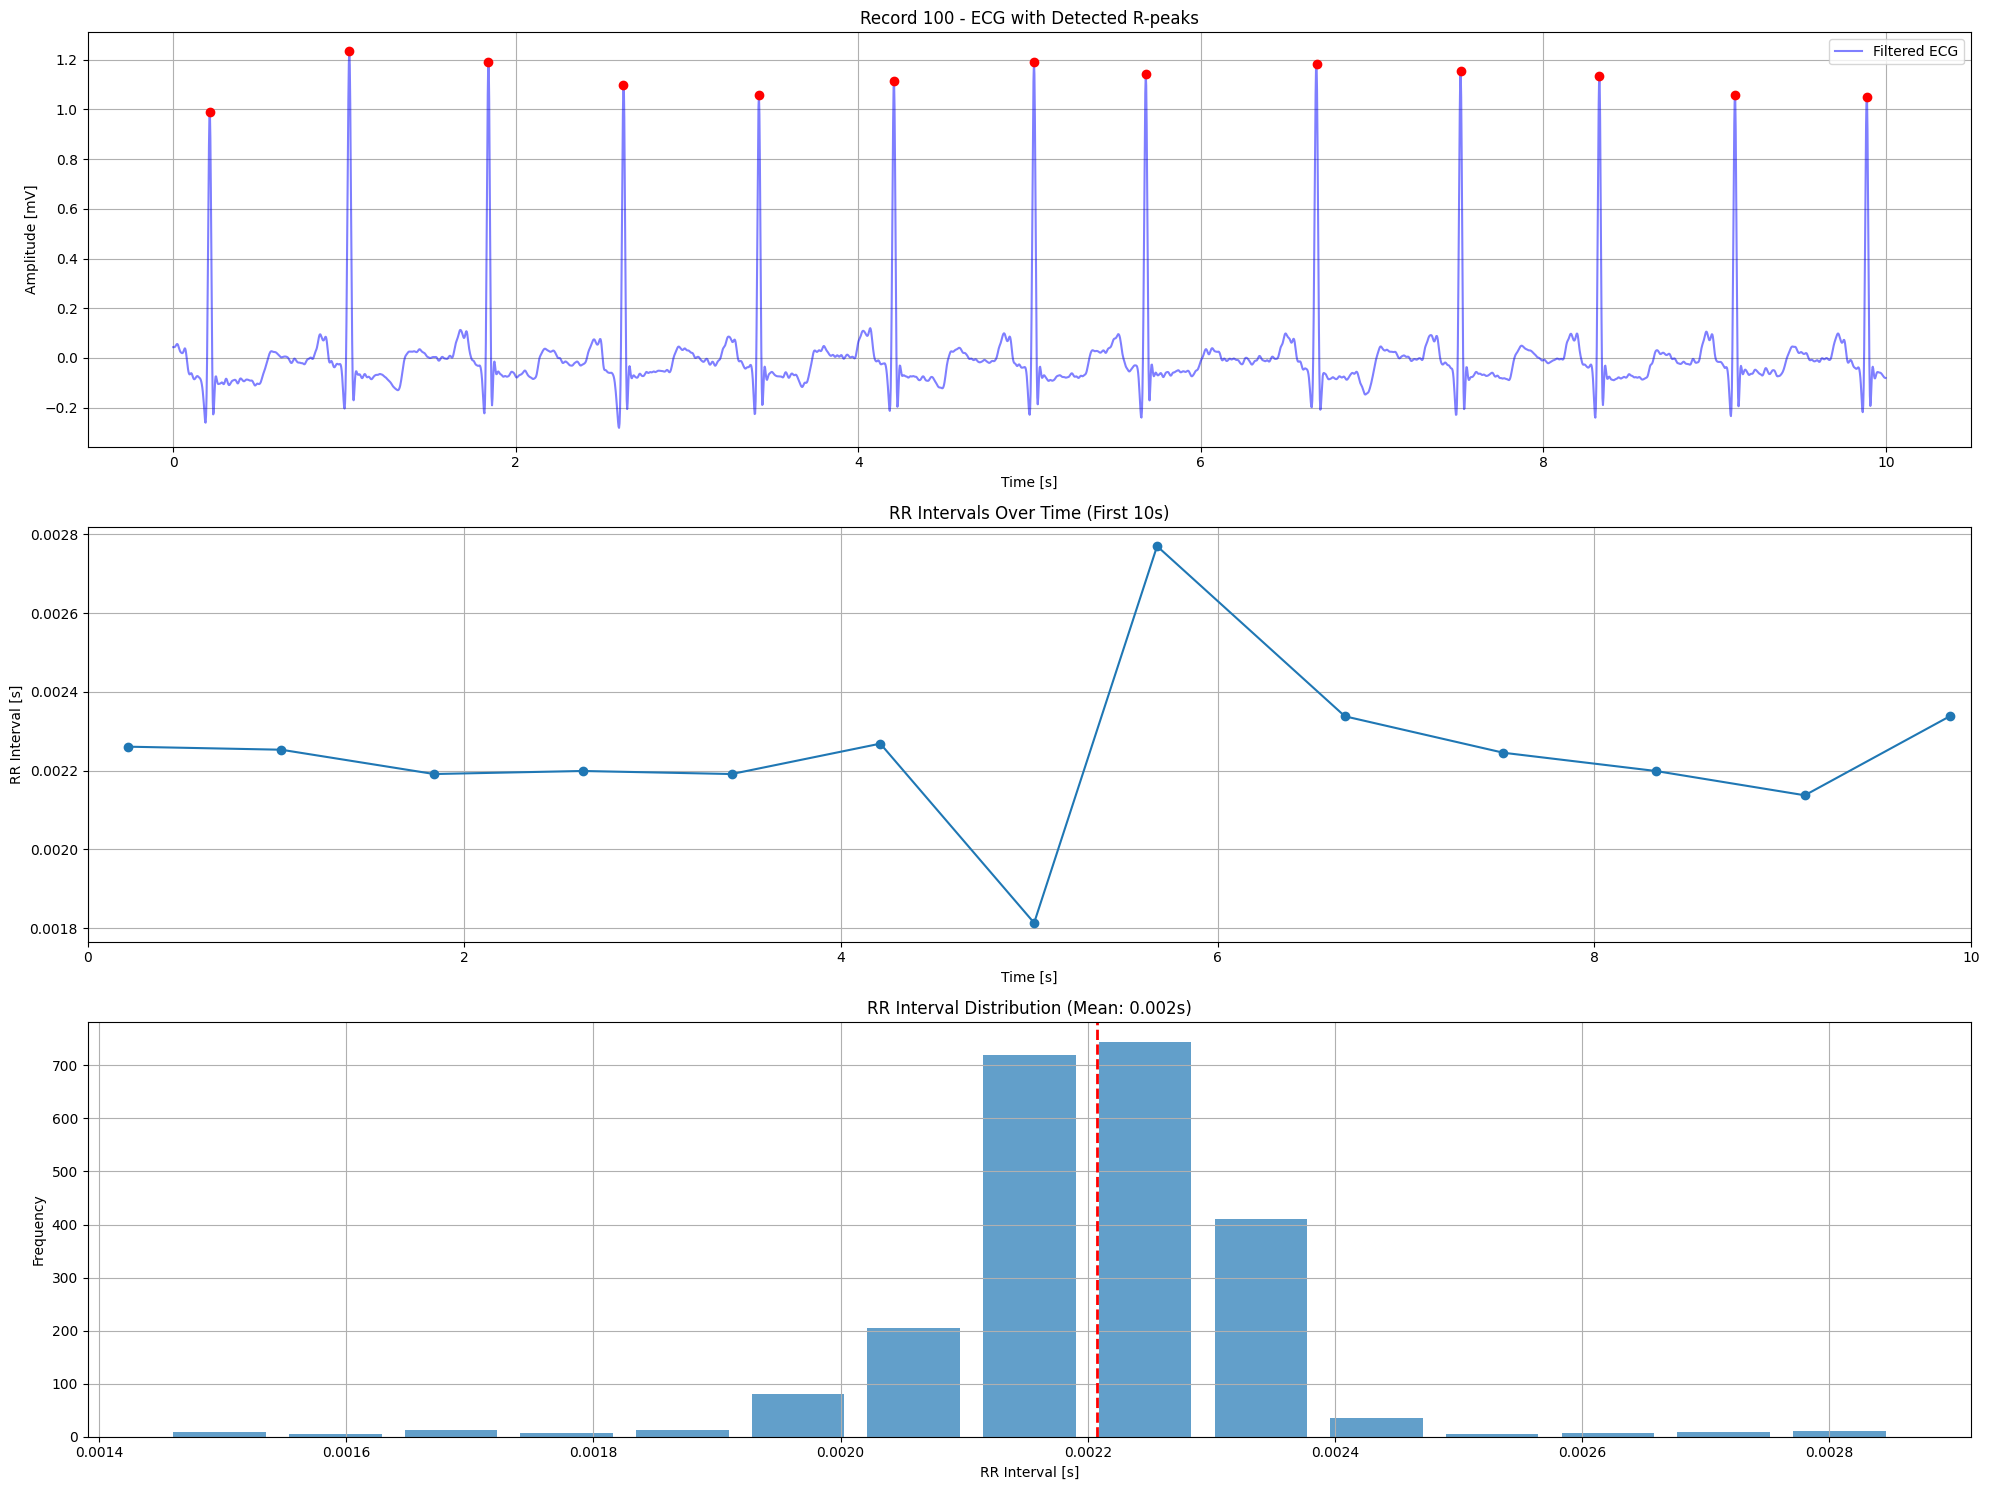

Heart Rate Analysis for Record 100:
- Average Heart Rate: 75.81 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0001 s
- RMSSD: 0.0002 s
- Mean RR Interval: 0.0022 s
- Min RR Interval: 0.0015 s
- Max RR Interval: 0.0029 s
- Heart Rate Standard Deviation: 5.00 BPM
- Heart Rate Min: 58.38 BPM
- Heart Rate Max: 114.89 BPM

----------------------------------------------------------------------
Processing R-peaks for record 101...


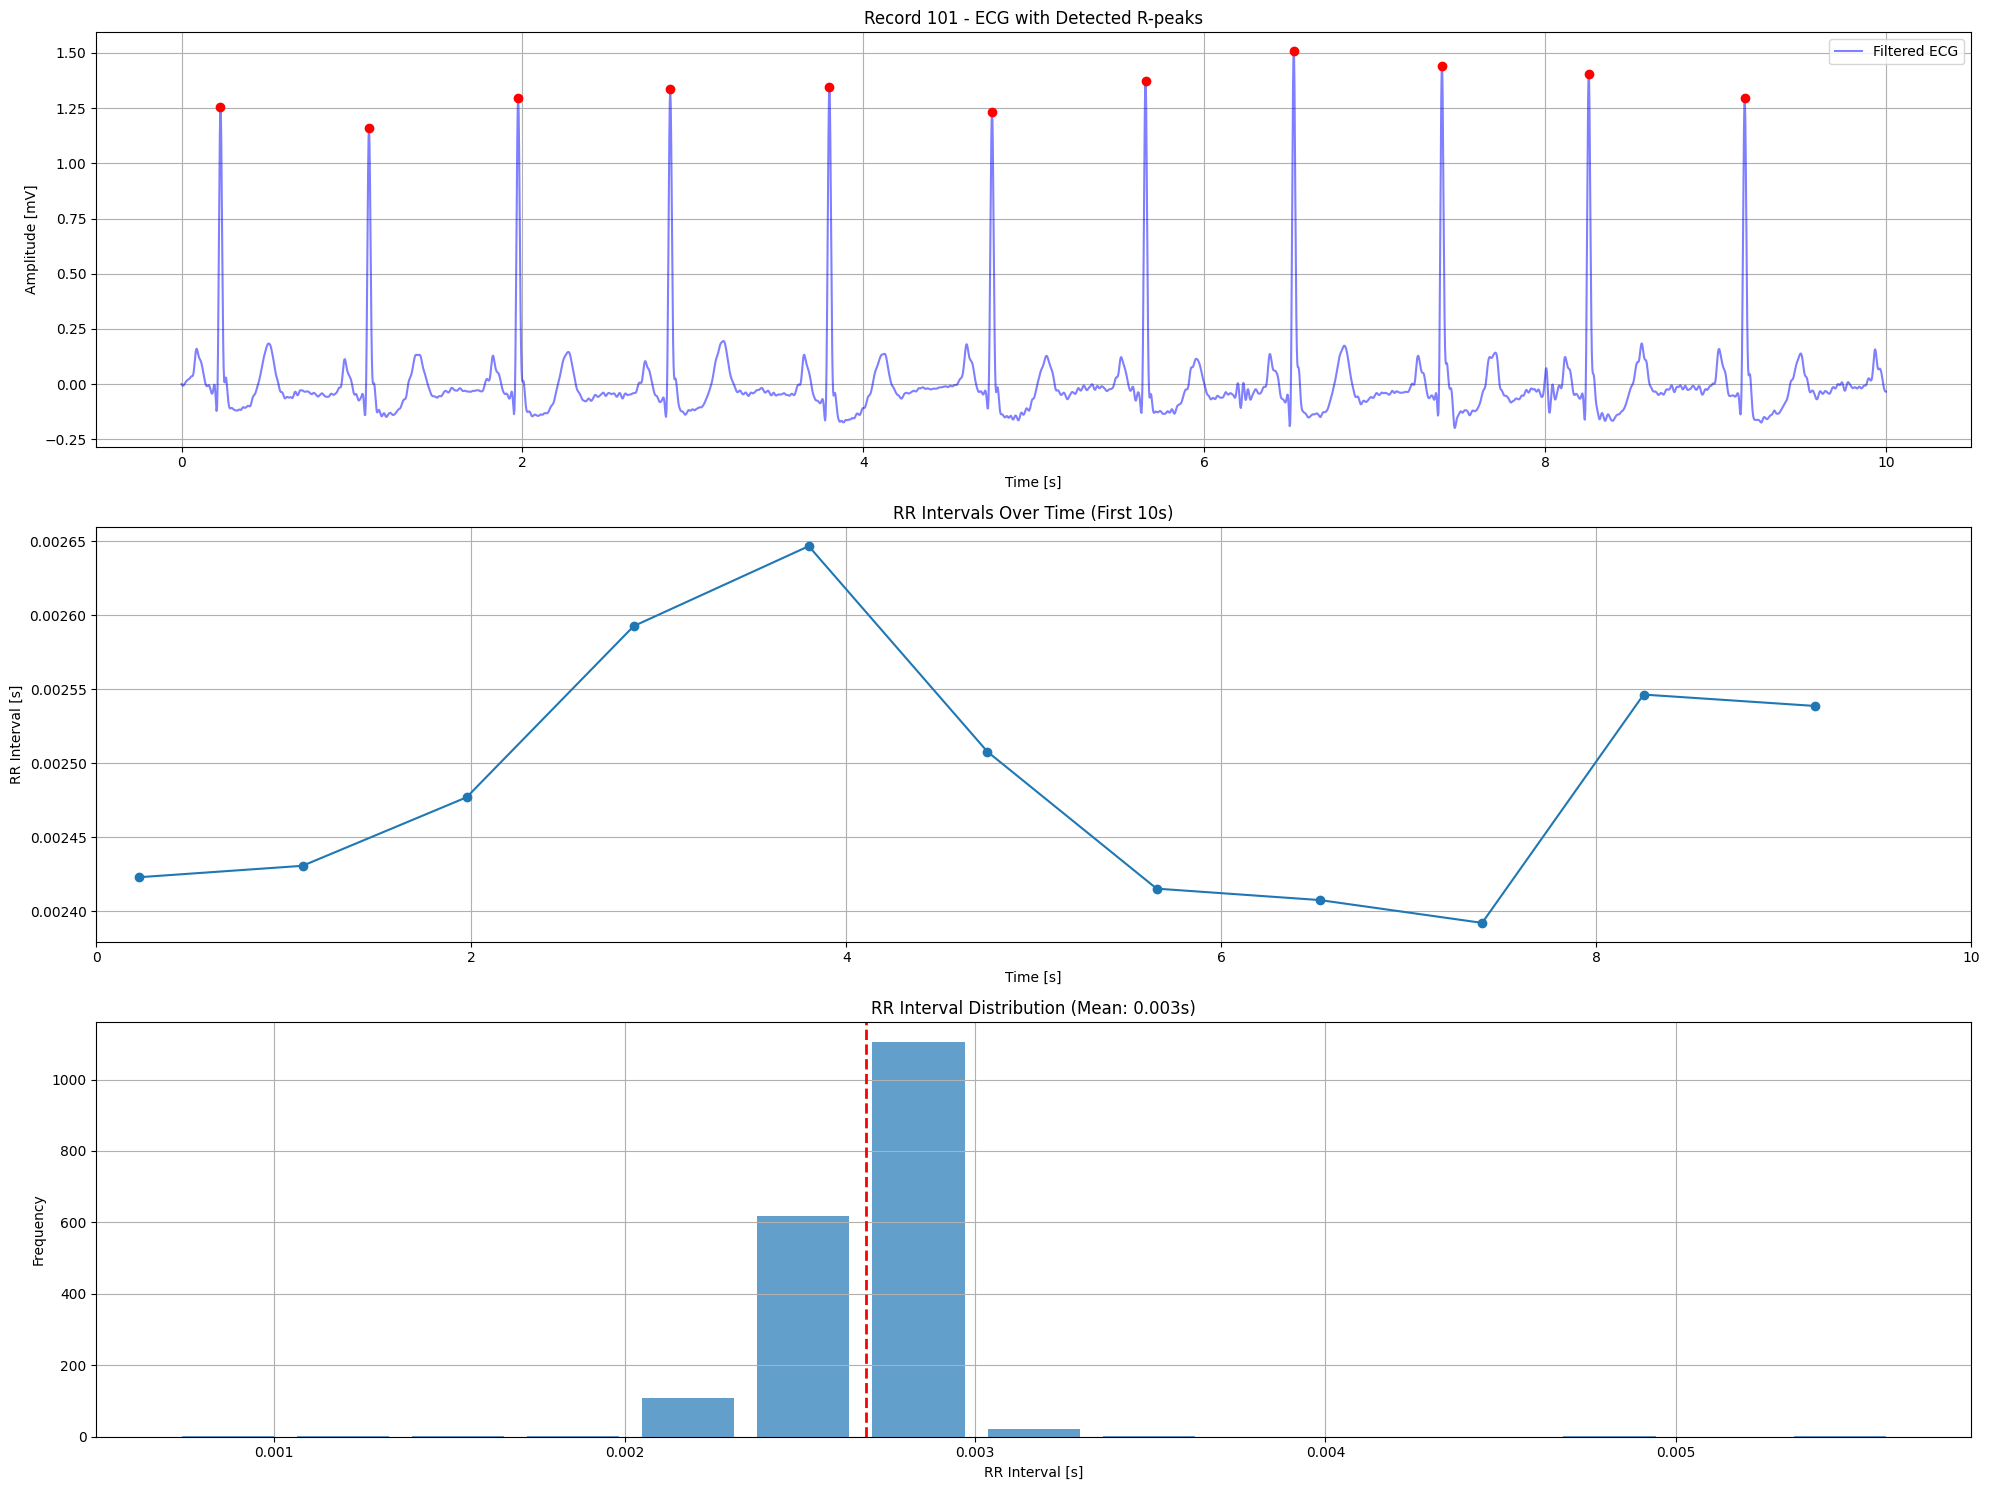

Heart Rate Analysis for Record 101:
- Average Heart Rate: 62.51 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0002 s
- RMSSD: 0.0002 s
- Mean RR Interval: 0.0027 s
- Min RR Interval: 0.0007 s
- Max RR Interval: 0.0056 s
- Heart Rate Standard Deviation: 7.50 BPM
- Heart Rate Min: 29.59 BPM
- Heart Rate Max: 237.36 BPM

----------------------------------------------------------------------
Processing R-peaks for record 102...


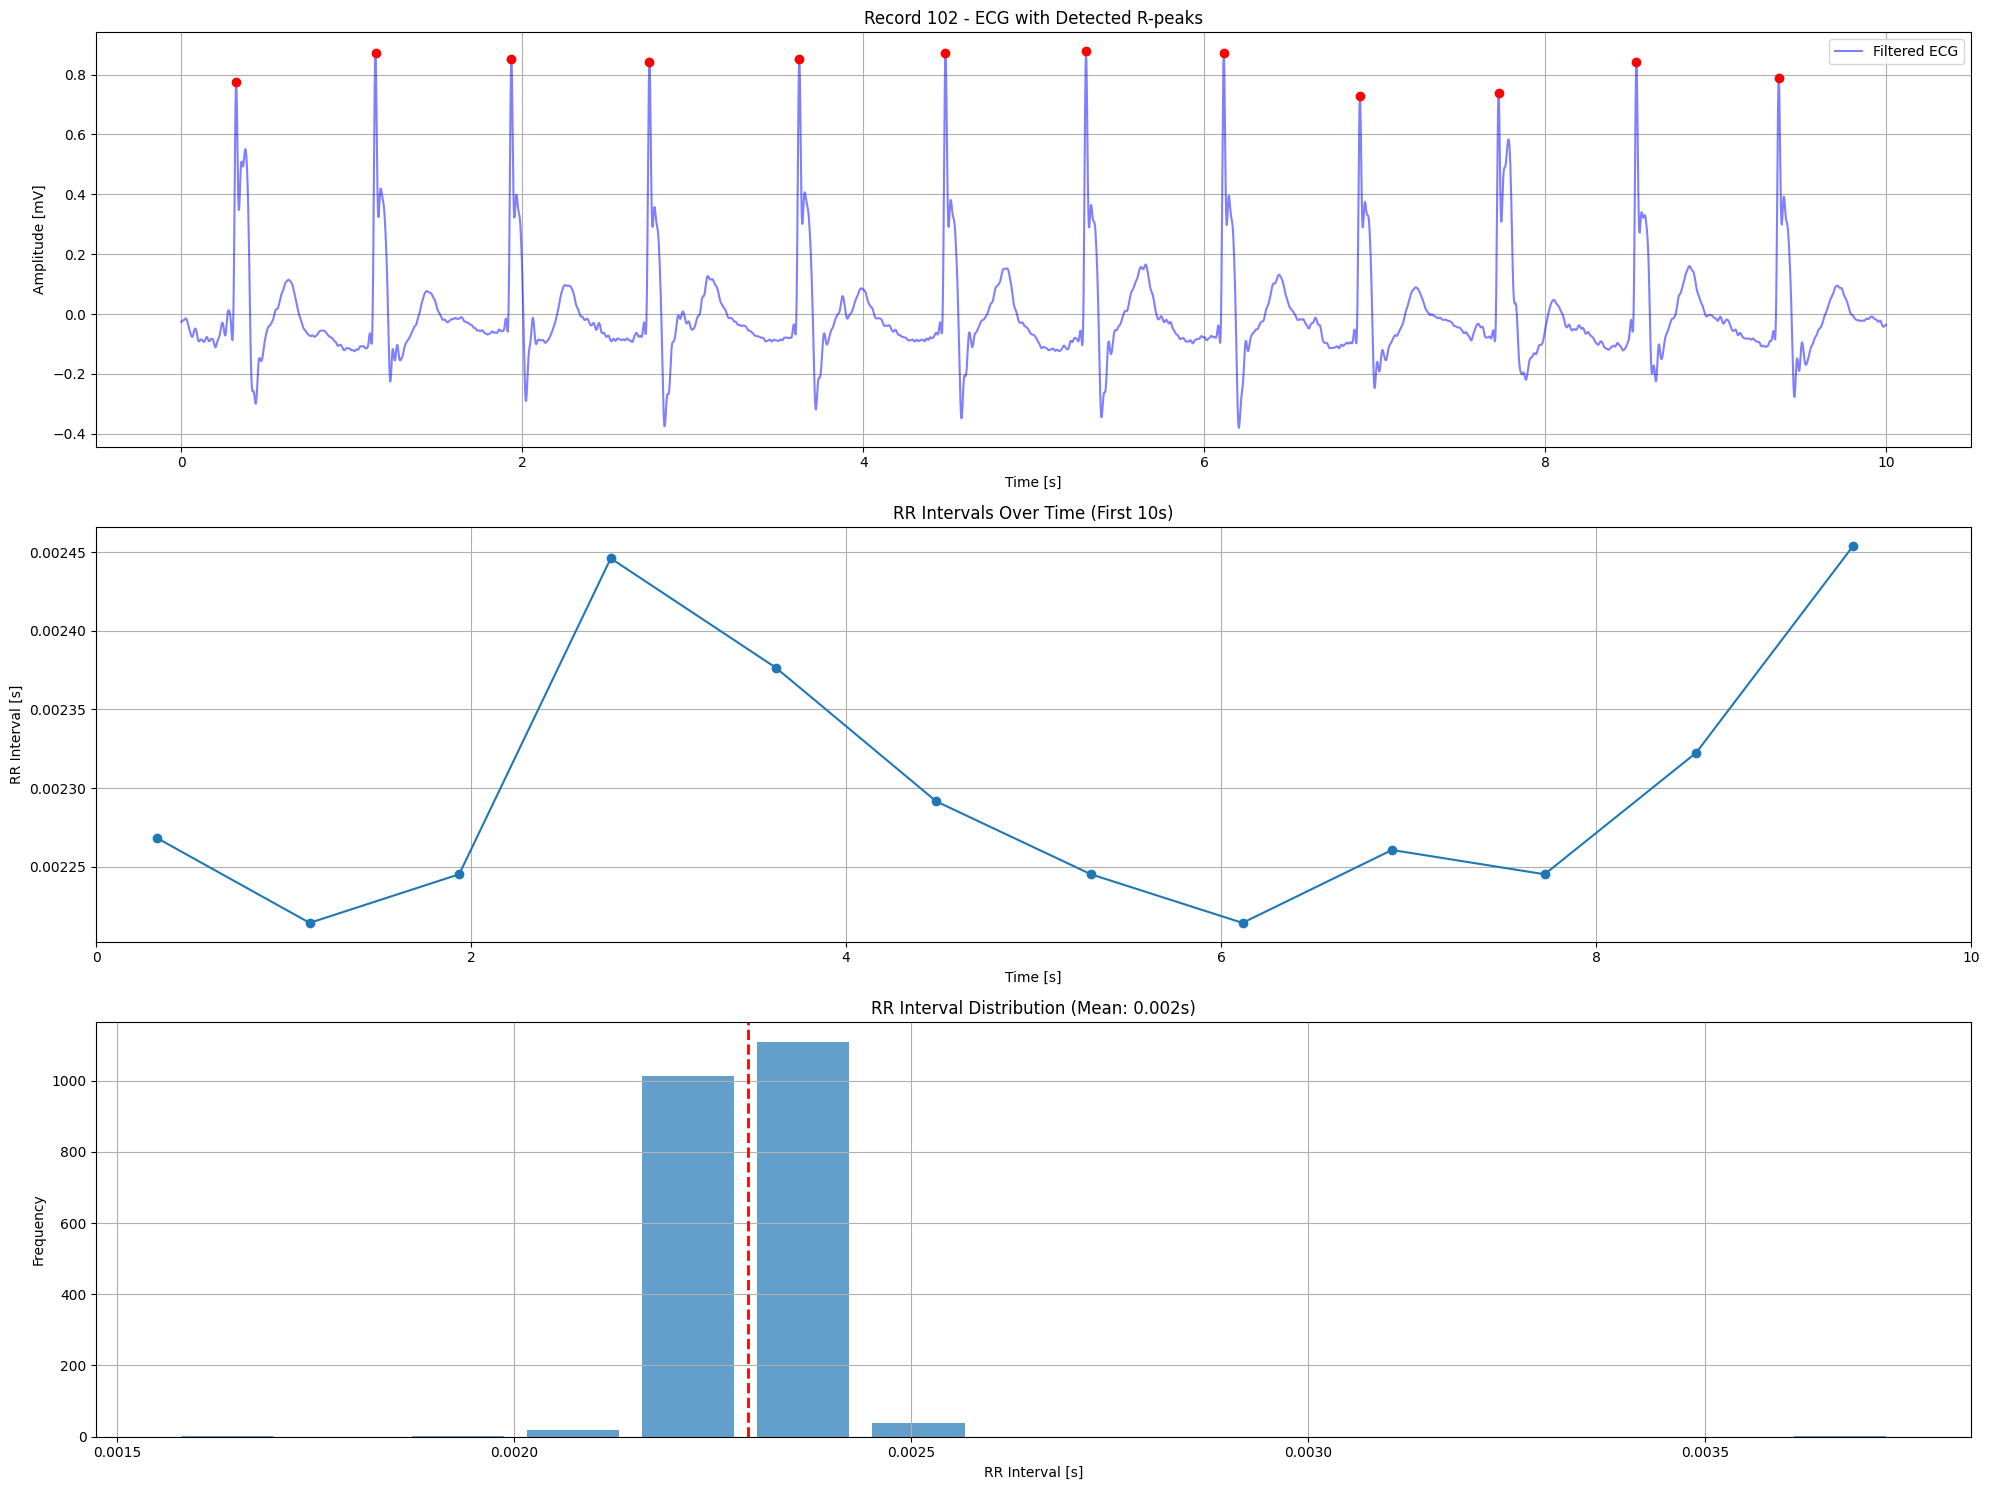

Heart Rate Analysis for Record 102:
- Average Heart Rate: 72.73 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0001 s
- RMSSD: 0.0001 s
- Mean RR Interval: 0.0023 s
- Min RR Interval: 0.0016 s
- Max RR Interval: 0.0037 s
- Heart Rate Standard Deviation: 2.53 BPM
- Heart Rate Min: 44.54 BPM
- Heart Rate Max: 106.40 BPM

----------------------------------------------------------------------
Processing R-peaks for record 103...


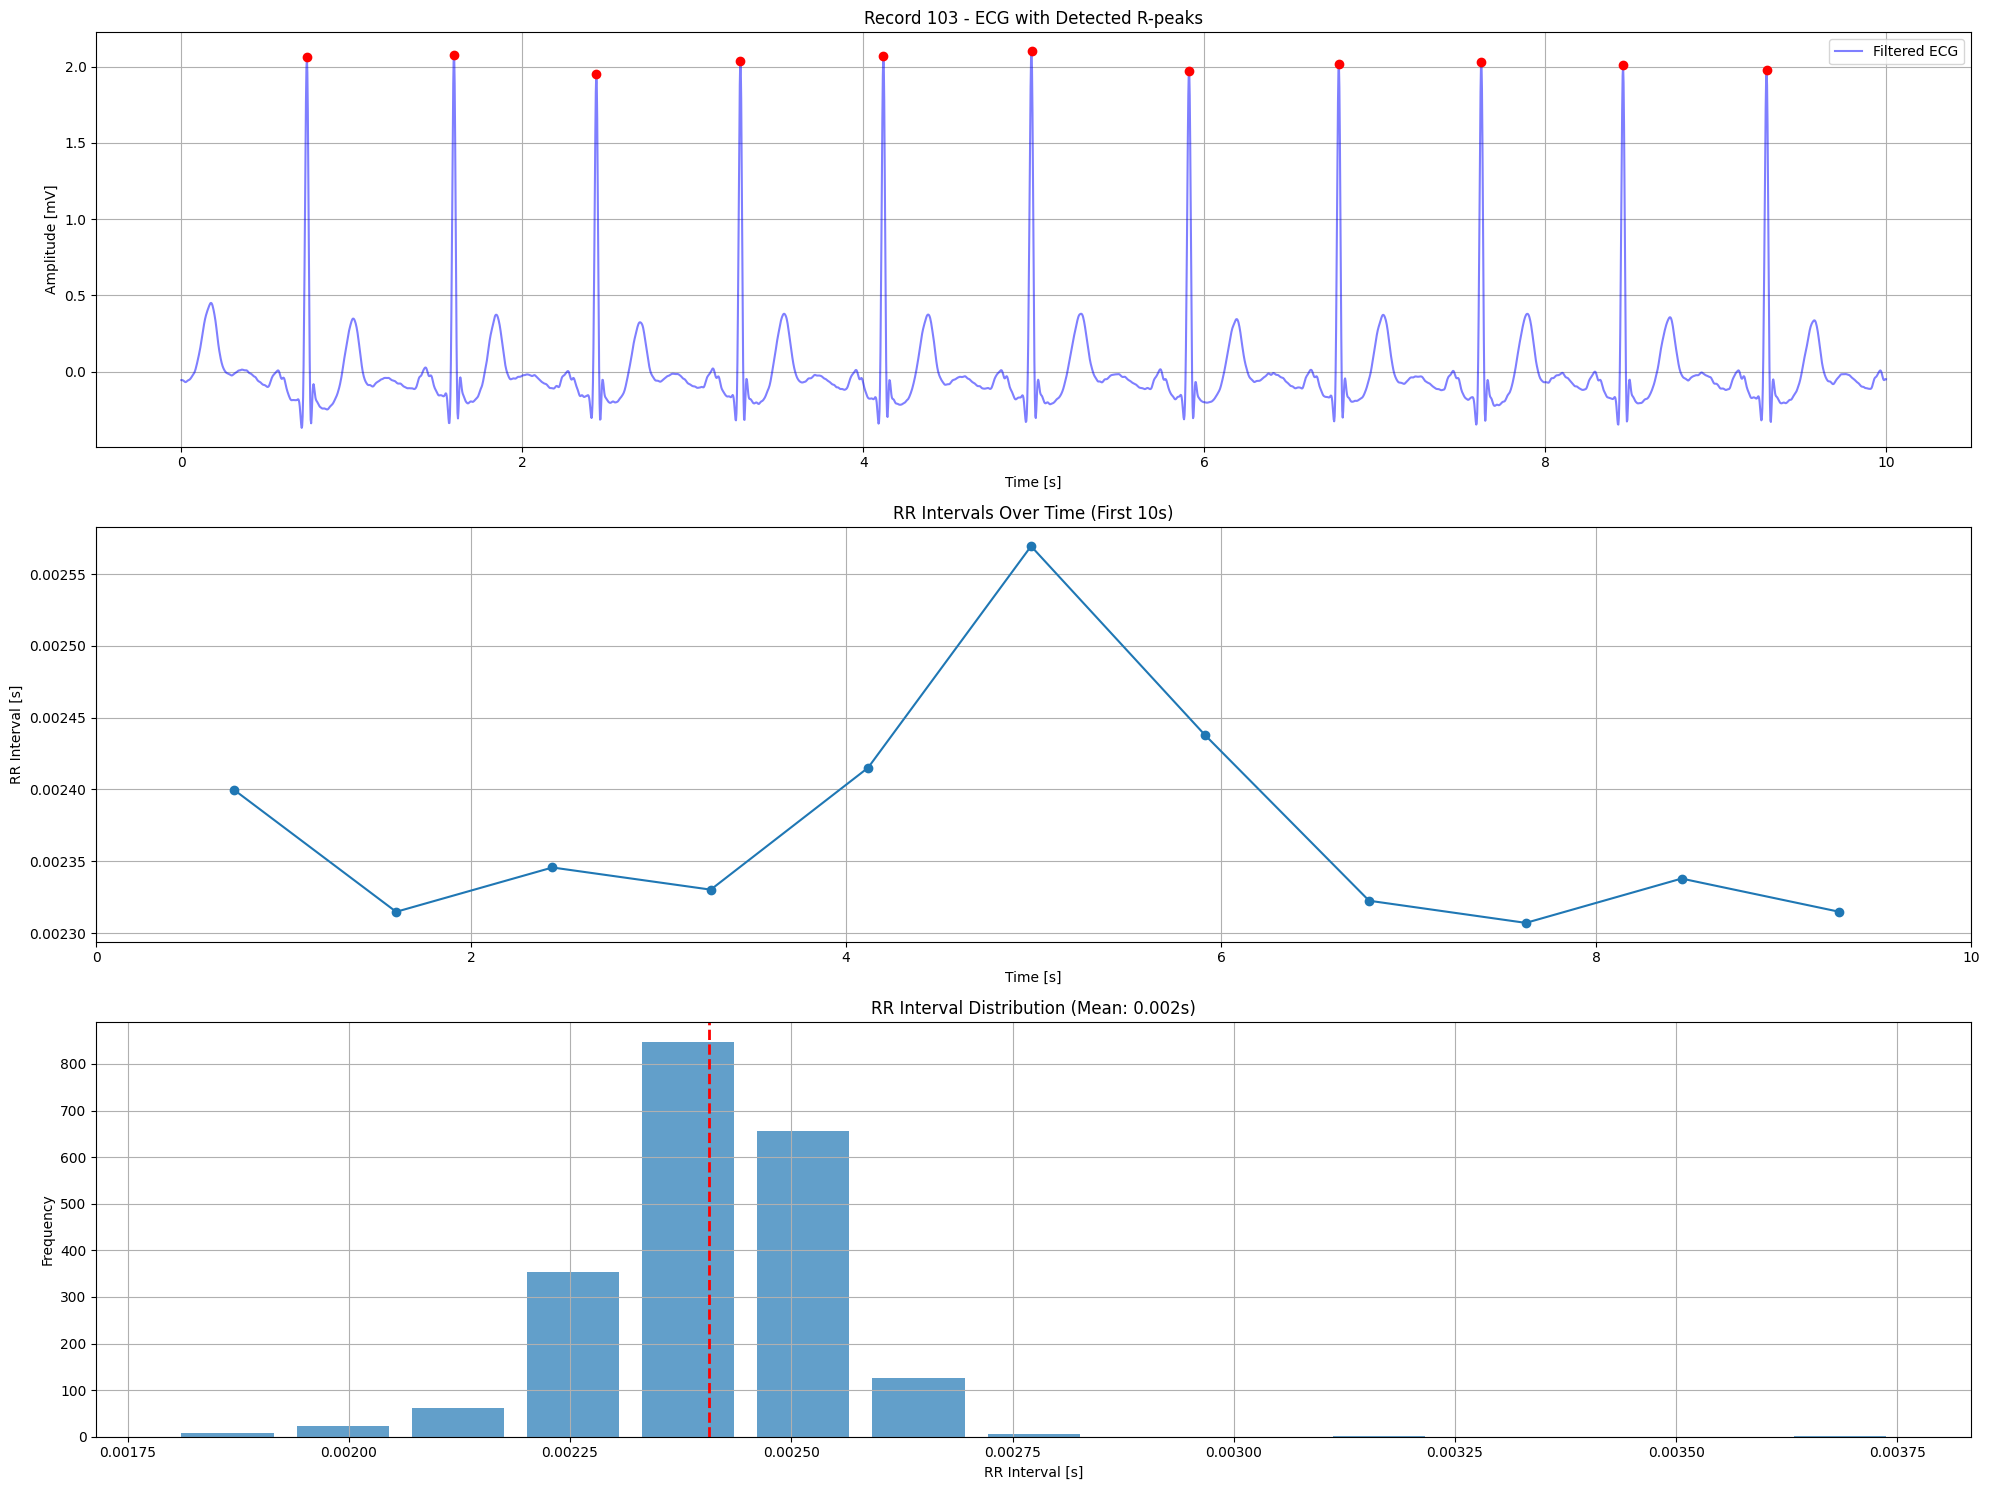

Heart Rate Analysis for Record 103:
- Average Heart Rate: 69.44 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0001 s
- RMSSD: 0.0001 s
- Mean RR Interval: 0.0024 s
- Min RR Interval: 0.0018 s
- Max RR Interval: 0.0038 s
- Heart Rate Standard Deviation: 3.92 BPM
- Heart Rate Min: 44.44 BPM
- Heart Rate Max: 92.70 BPM

----------------------------------------------------------------------
Processing R-peaks for record 104...


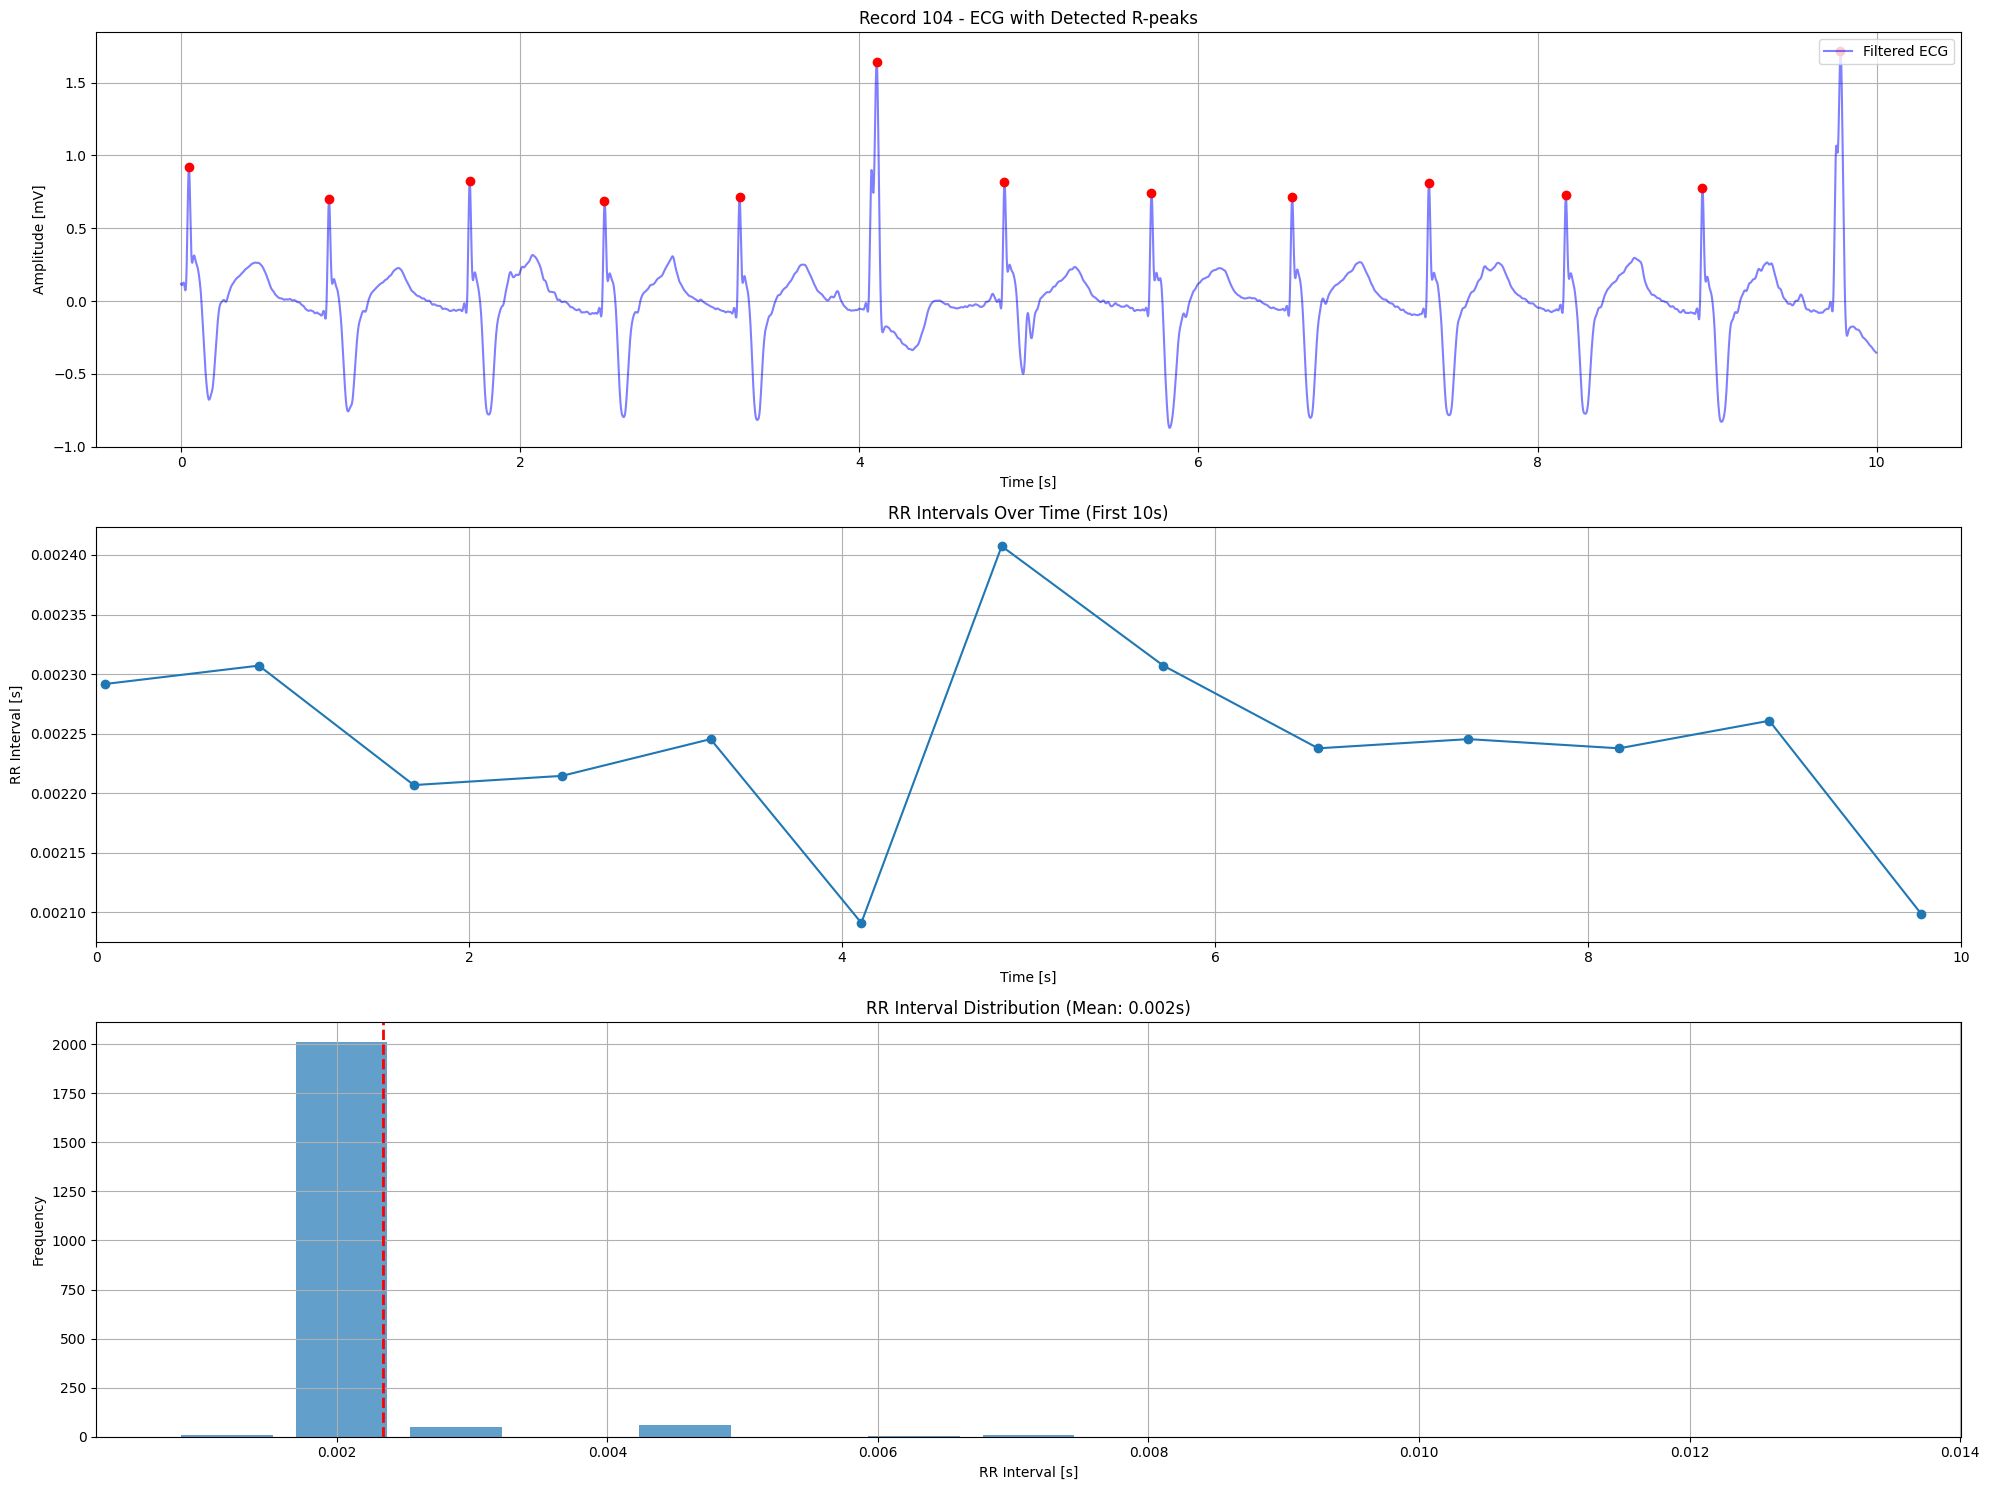

Heart Rate Analysis for Record 104:
- Average Heart Rate: 73.15 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0006 s
- RMSSD: 0.0008 s
- Mean RR Interval: 0.0023 s
- Min RR Interval: 0.0008 s
- Max RR Interval: 0.0135 s
- Heart Rate Standard Deviation: 9.84 BPM
- Heart Rate Min: 12.38 BPM
- Heart Rate Max: 218.18 BPM

----------------------------------------------------------------------
Processing R-peaks for record 105...


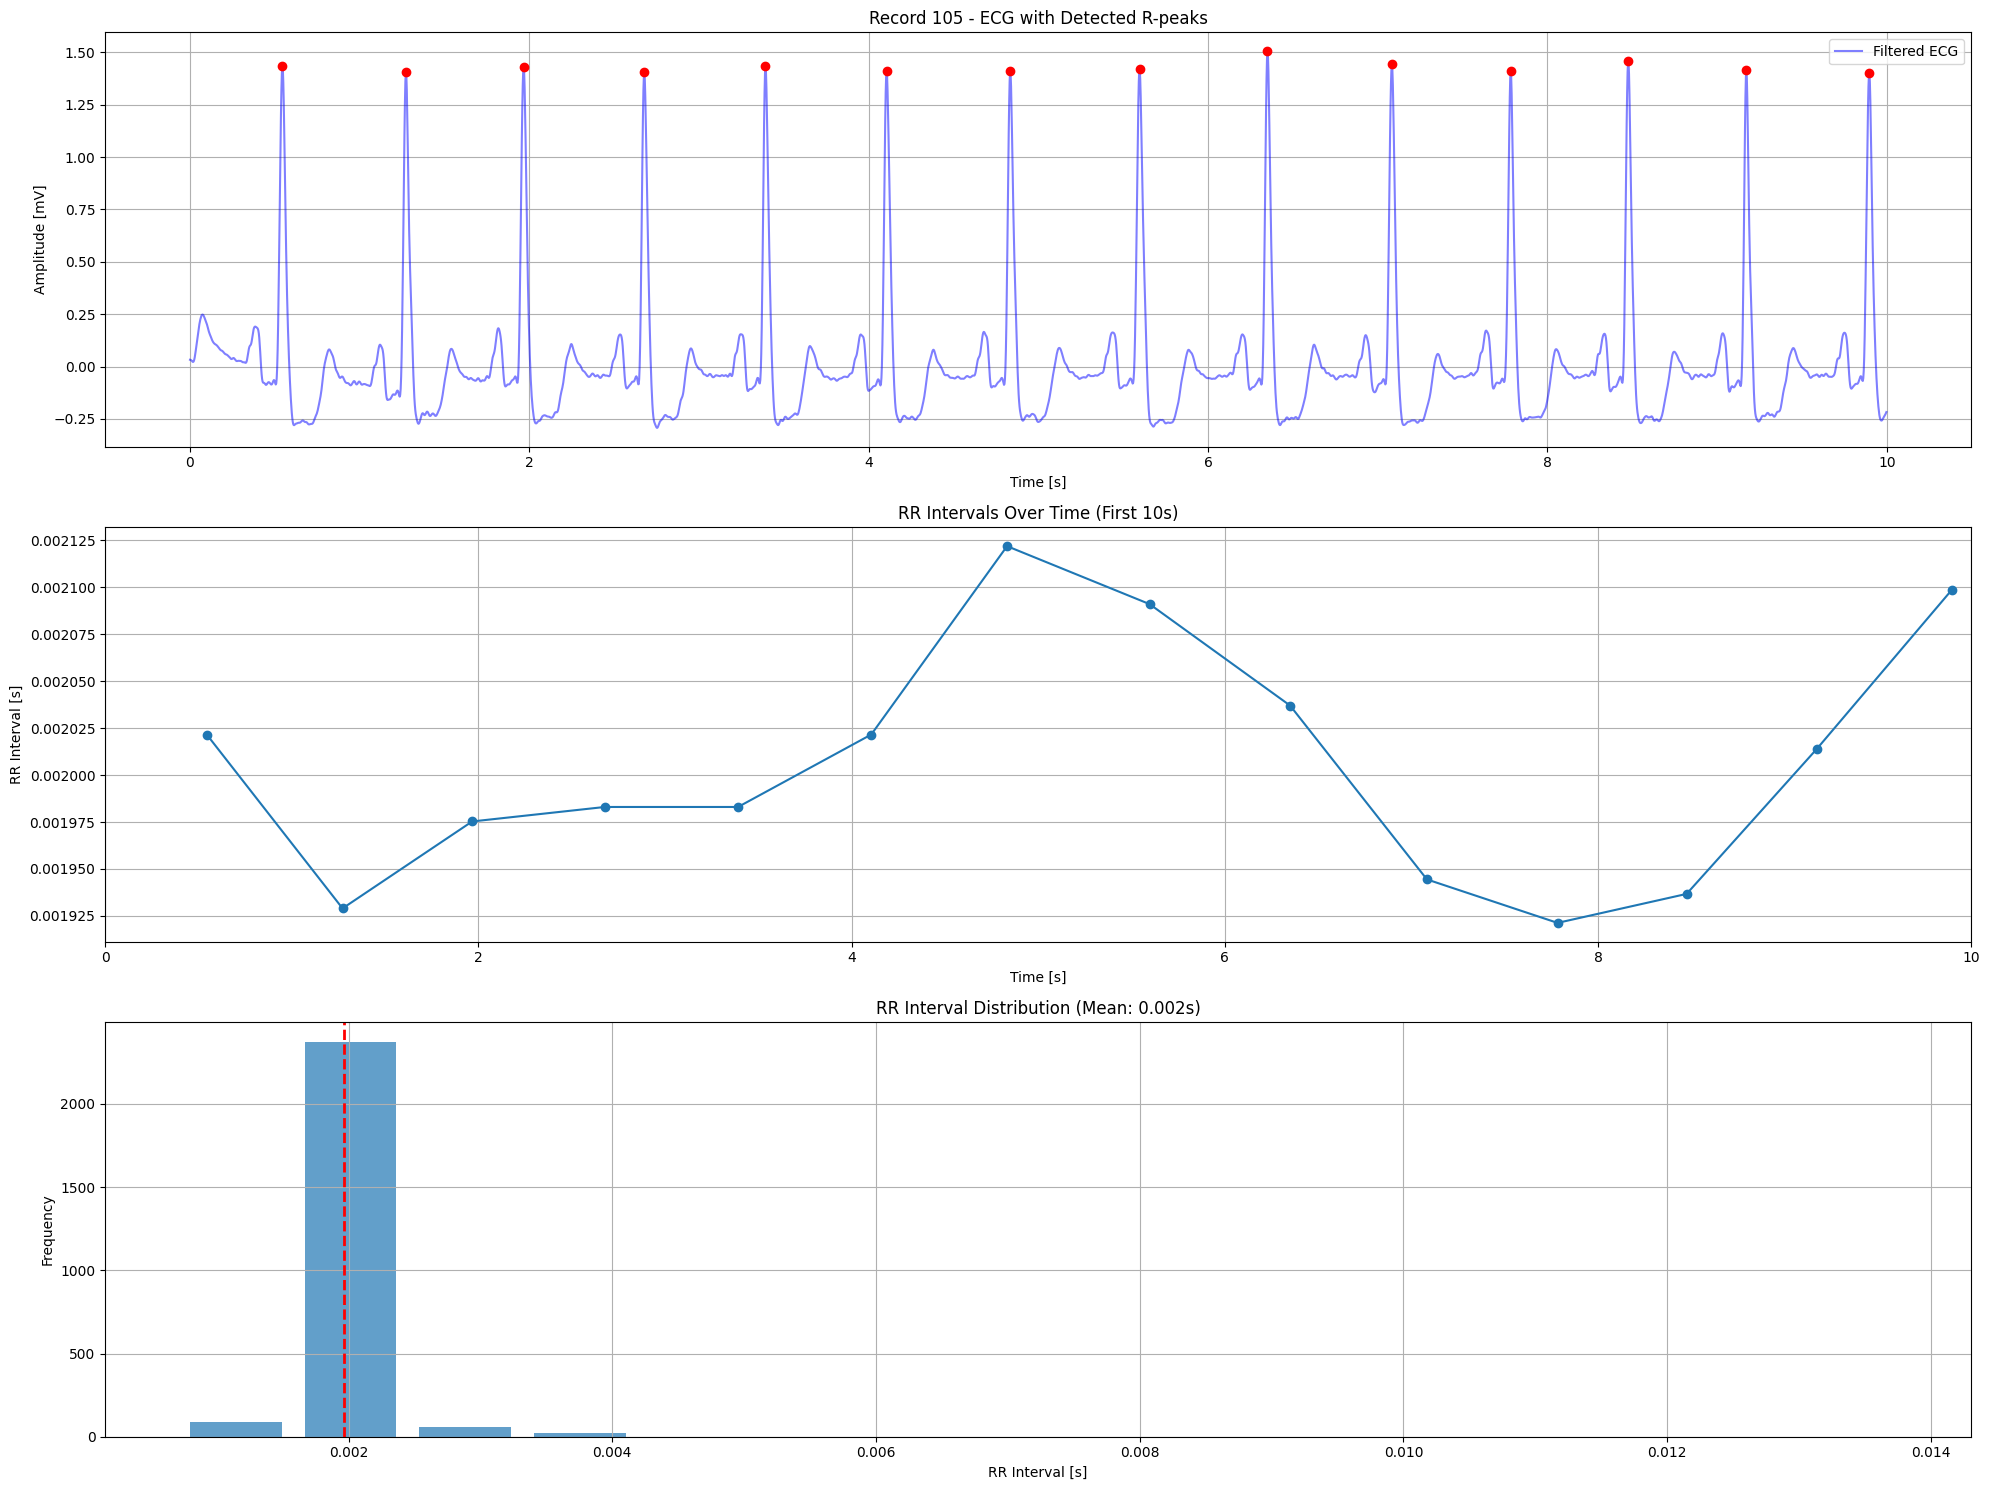

Heart Rate Analysis for Record 105:
- Average Heart Rate: 87.07 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0004 s
- RMSSD: 0.0006 s
- Mean RR Interval: 0.0020 s
- Min RR Interval: 0.0007 s
- Max RR Interval: 0.0138 s
- Heart Rate Standard Deviation: 16.99 BPM
- Heart Rate Min: 12.12 BPM
- Heart Rate Max: 234.78 BPM

----------------------------------------------------------------------
Processing R-peaks for record 108...


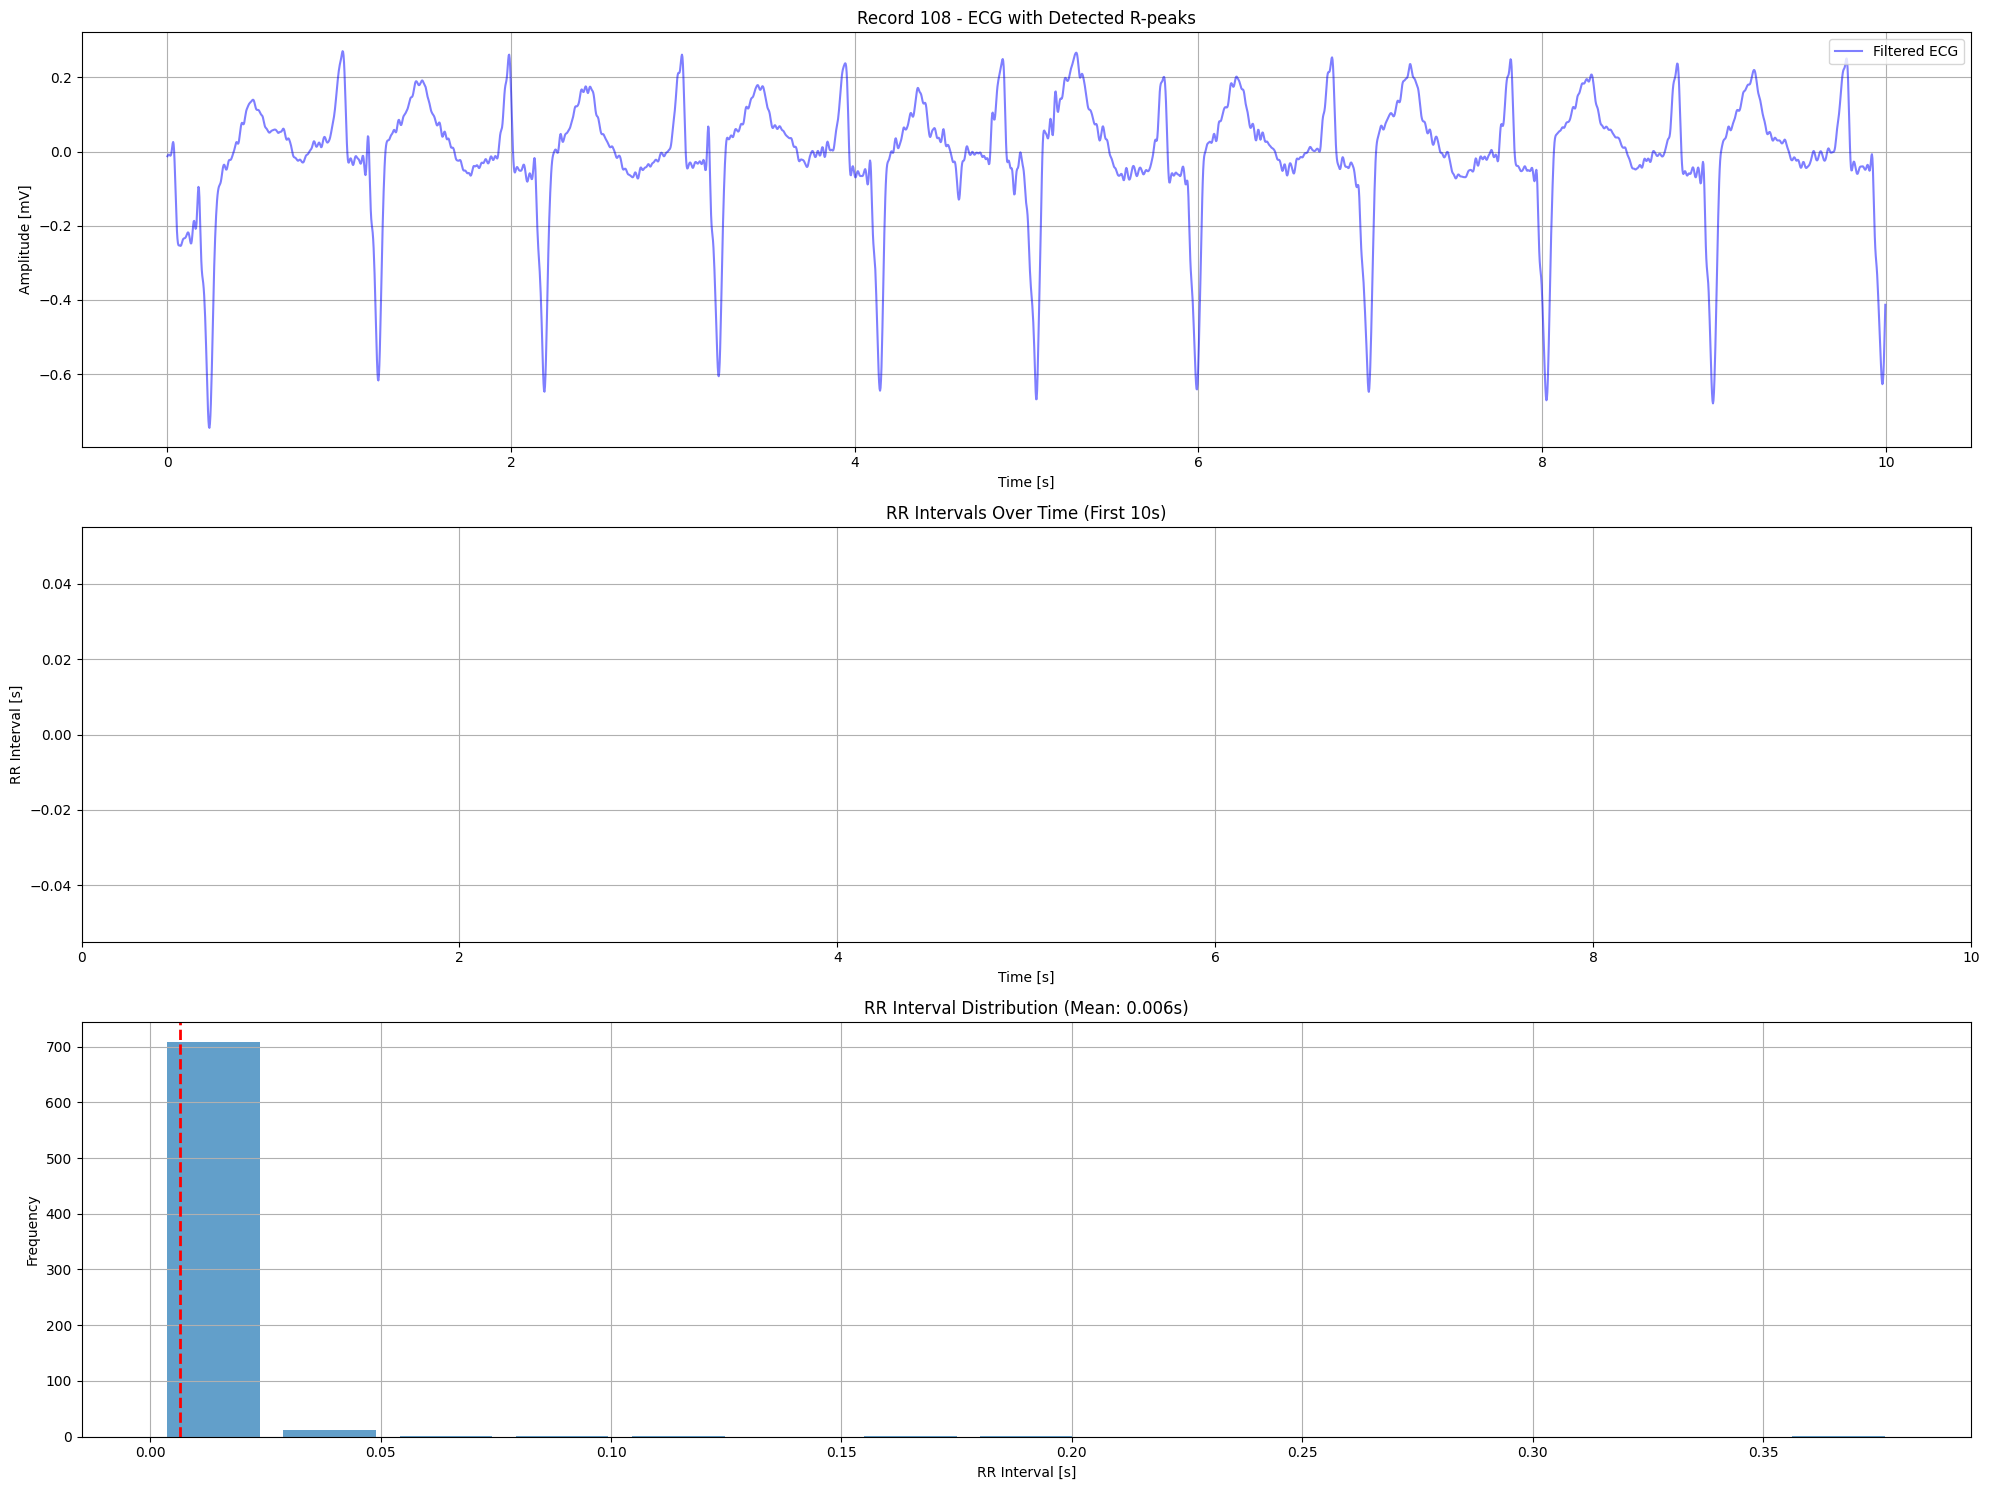

Heart Rate Analysis for Record 108:
- Average Heart Rate: 49.83 BPM
- Classification: Bradycardia (heart rate < 60 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0230 s
- RMSSD: 0.0262 s
- Mean RR Interval: 0.0064 s
- Min RR Interval: 0.0012 s
- Max RR Interval: 0.3791 s
- Heart Rate Standard Deviation: 16.66 BPM
- Heart Rate Min: 0.44 BPM
- Heart Rate Max: 141.18 BPM

----------------------------------------------------------------------
Processing R-peaks for record 114...


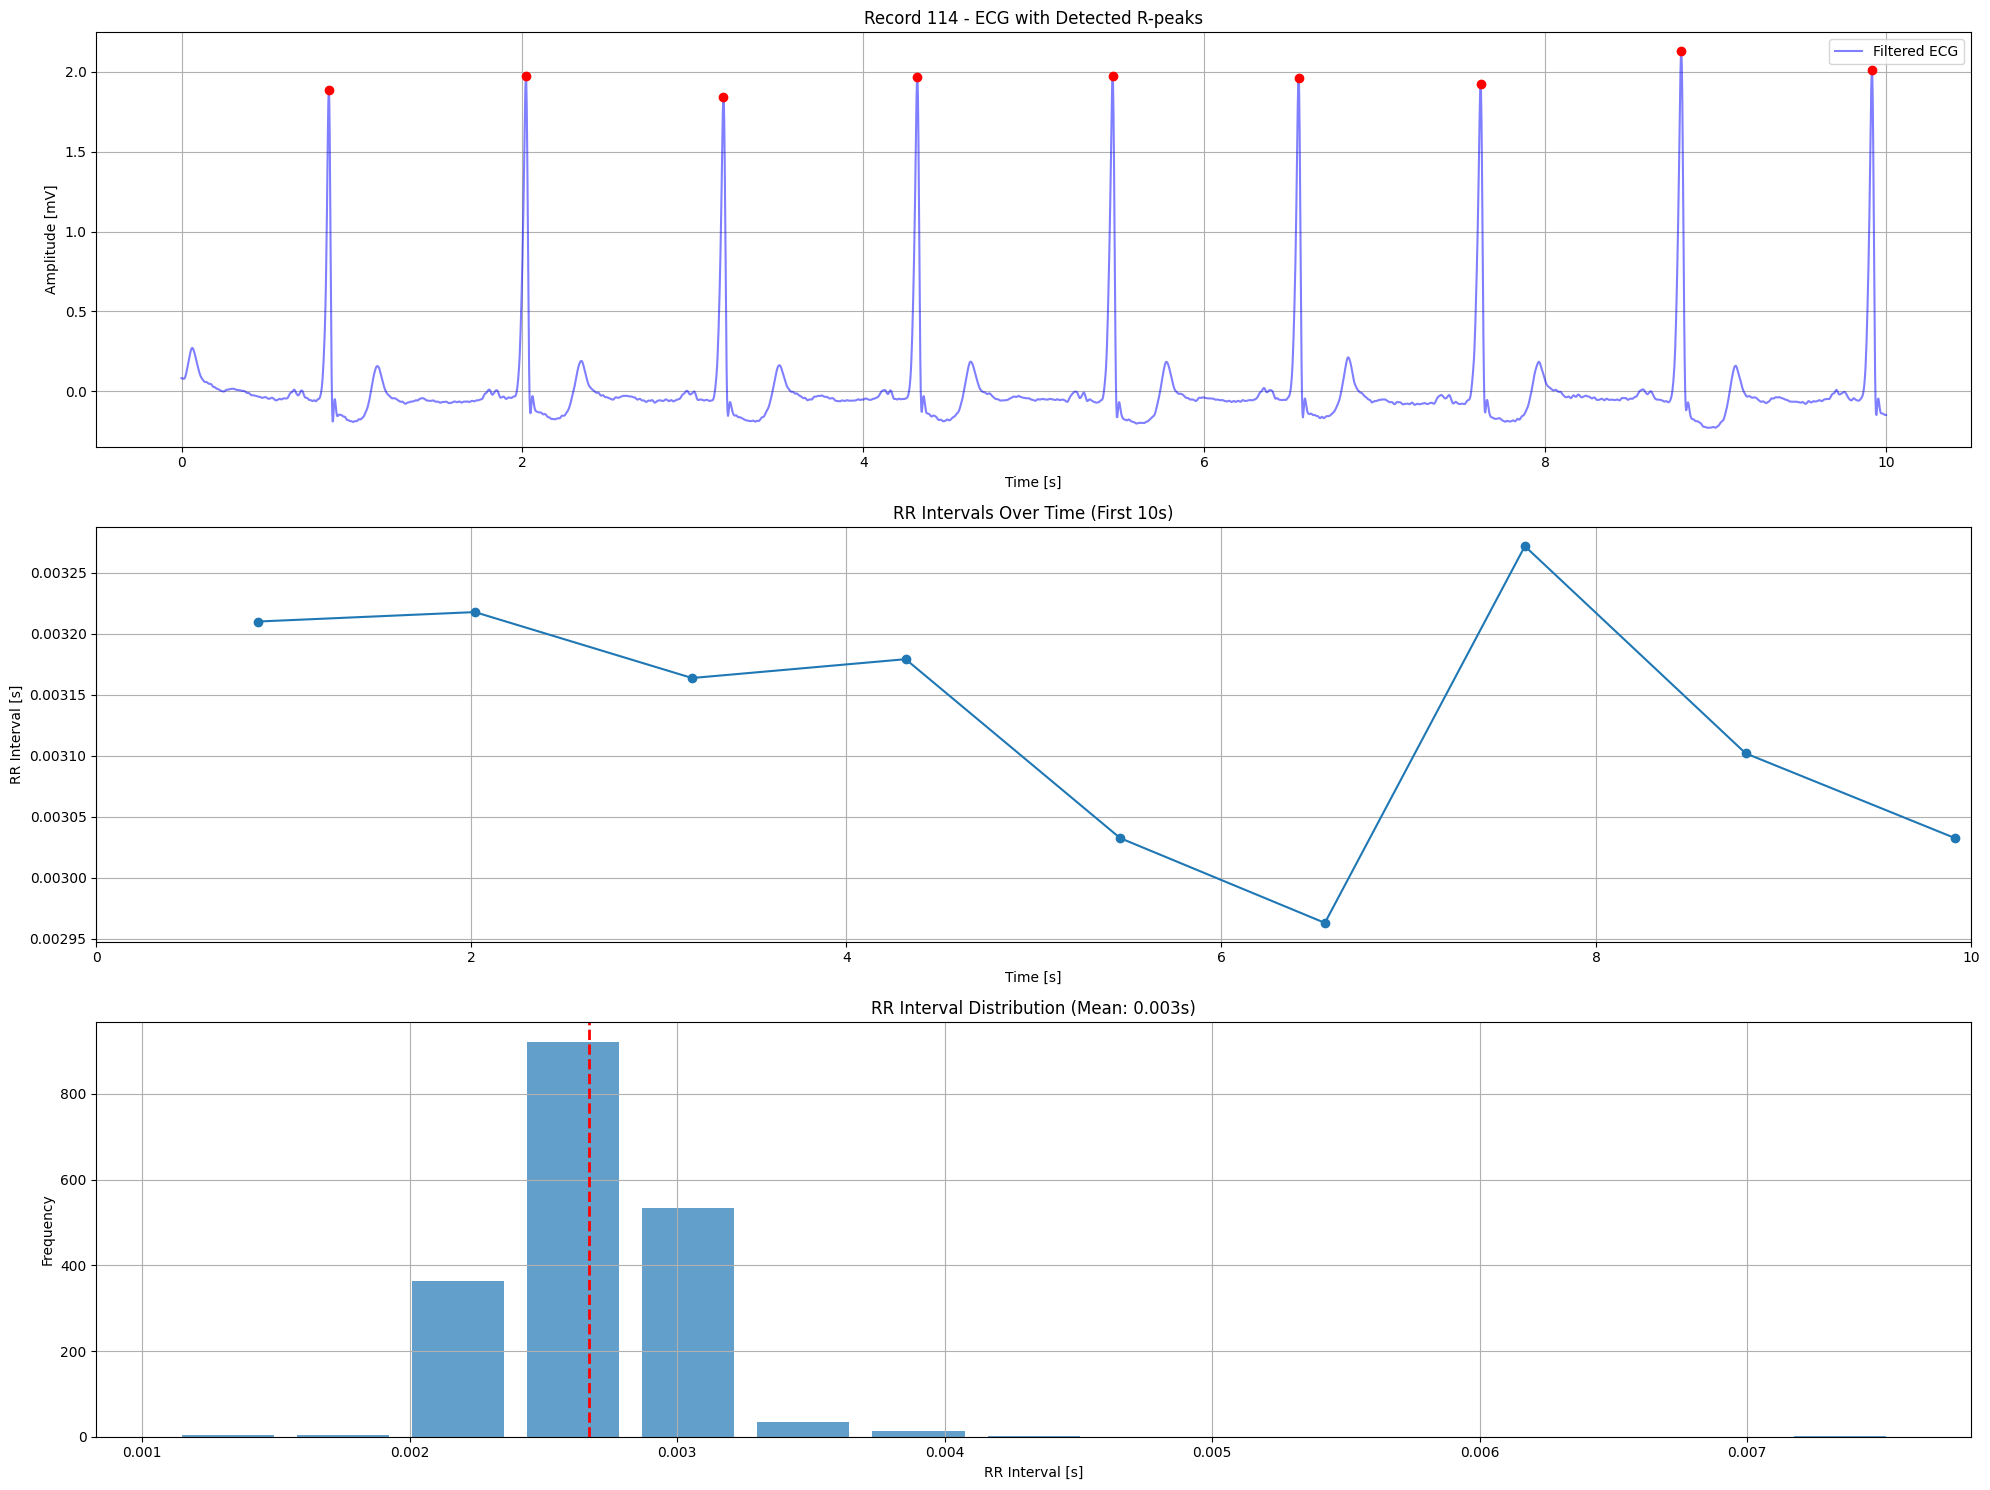

Heart Rate Analysis for Record 114:
- Average Heart Rate: 63.32 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0003 s
- RMSSD: 0.0003 s
- Mean RR Interval: 0.0027 s
- Min RR Interval: 0.0011 s
- Max RR Interval: 0.0076 s
- Heart Rate Standard Deviation: 7.88 BPM
- Heart Rate Min: 22.04 BPM
- Heart Rate Max: 151.05 BPM

----------------------------------------------------------------------
Processing R-peaks for record 118...


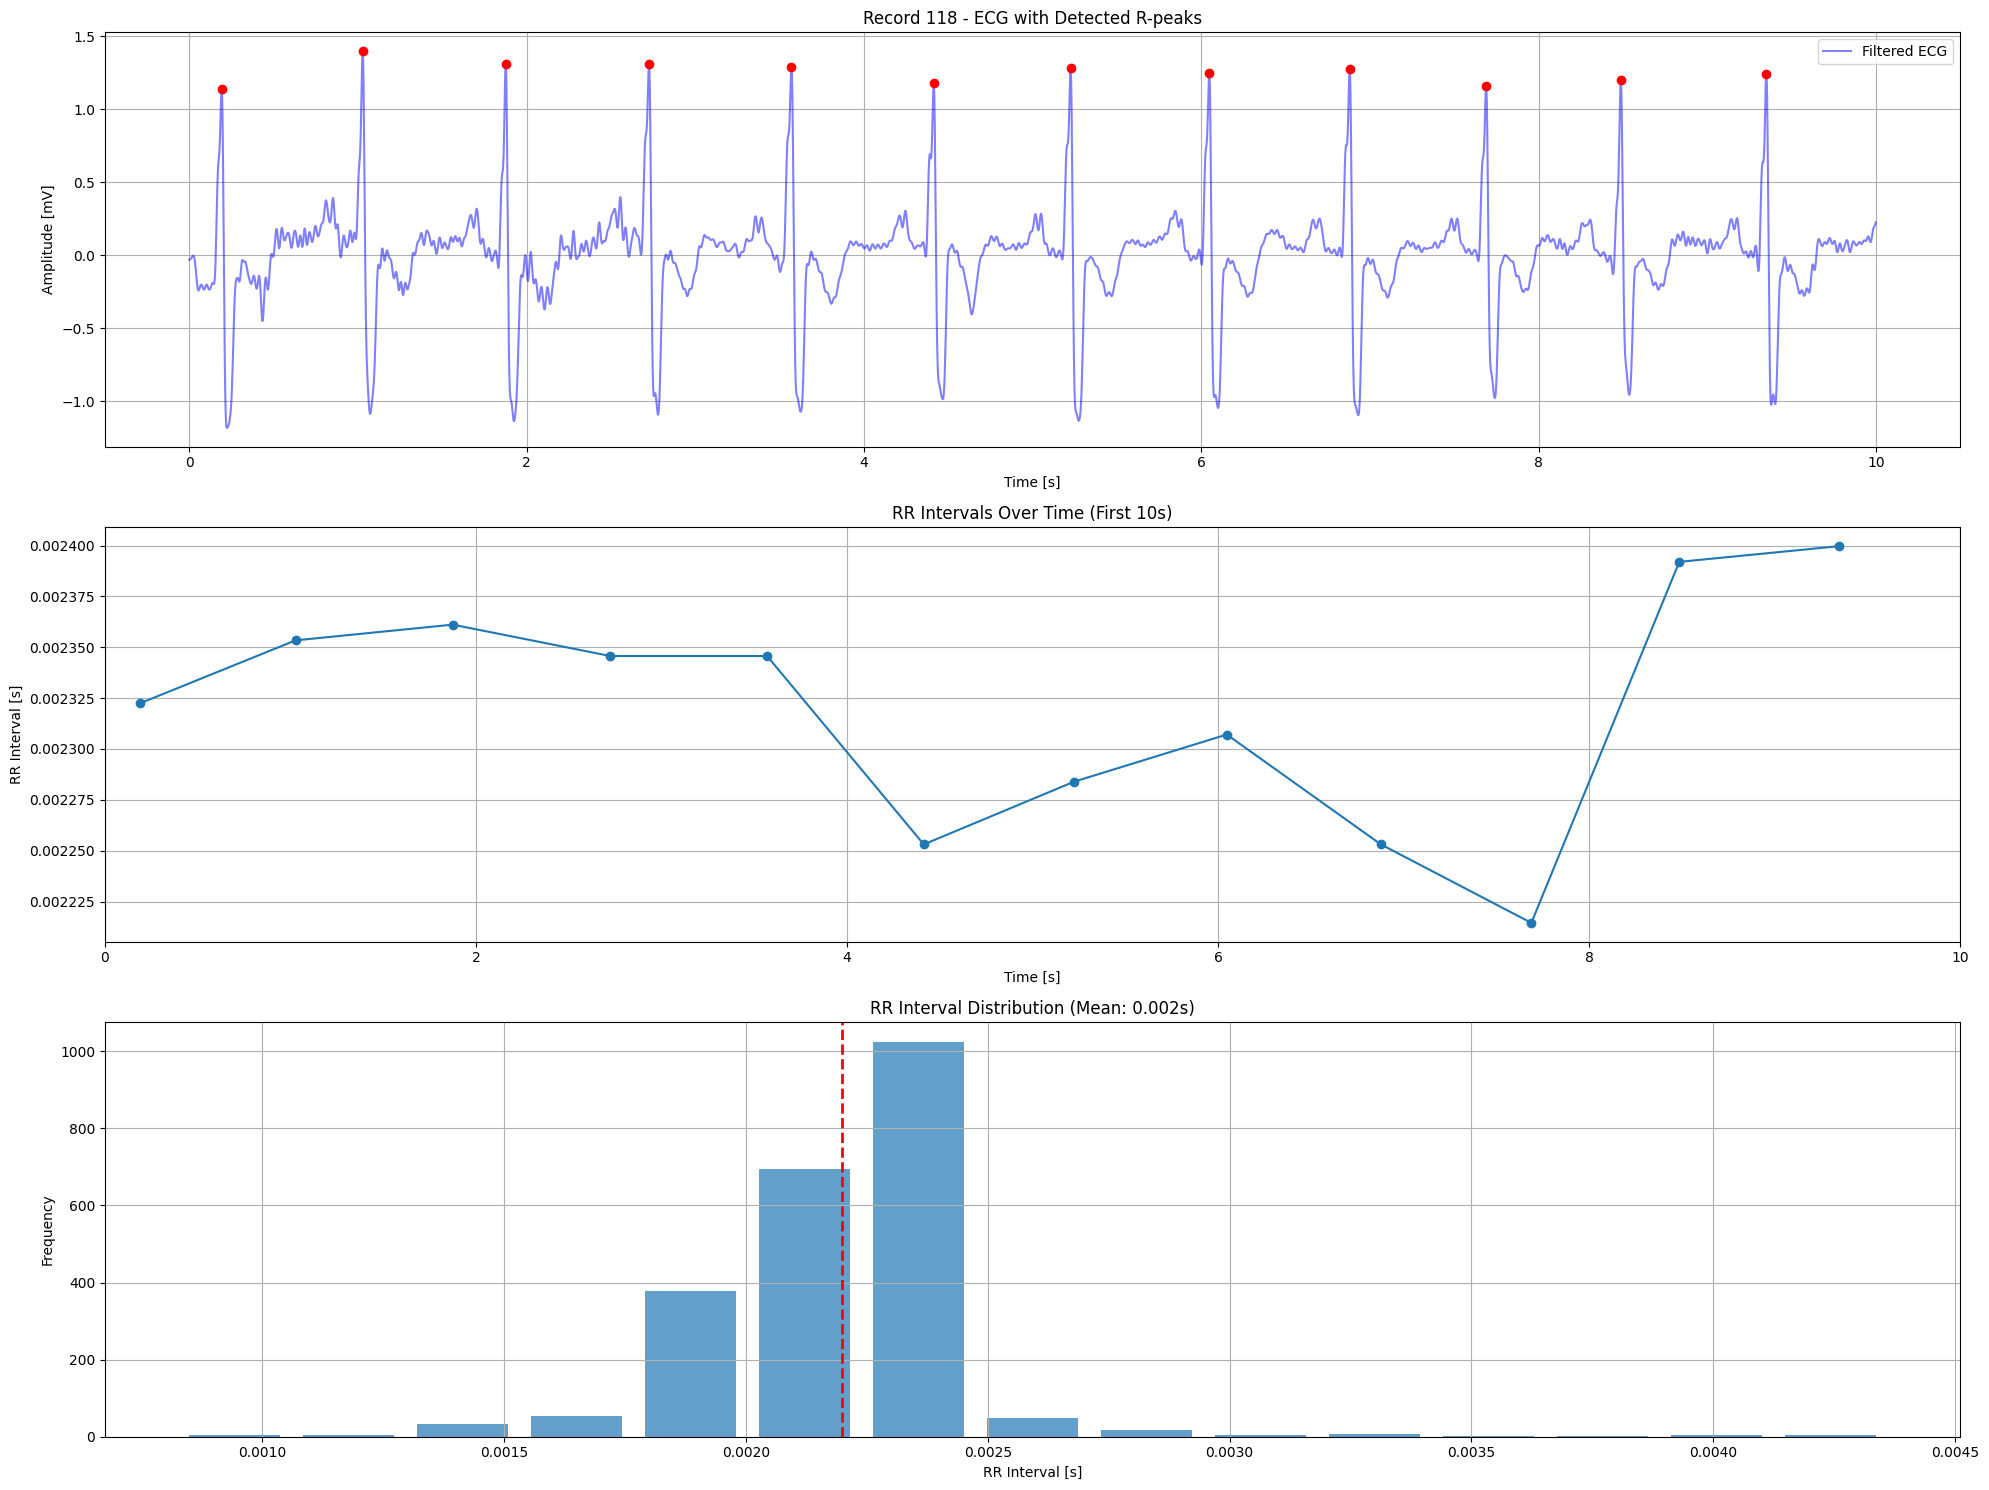

Heart Rate Analysis for Record 118:
- Average Heart Rate: 76.96 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0003 s
- RMSSD: 0.0003 s
- Mean RR Interval: 0.0022 s
- Min RR Interval: 0.0008 s
- Max RR Interval: 0.0044 s
- Heart Rate Standard Deviation: 10.29 BPM
- Heart Rate Min: 38.23 BPM
- Heart Rate Max: 201.87 BPM

----------------------------------------------------------------------
Processing R-peaks for record 124...


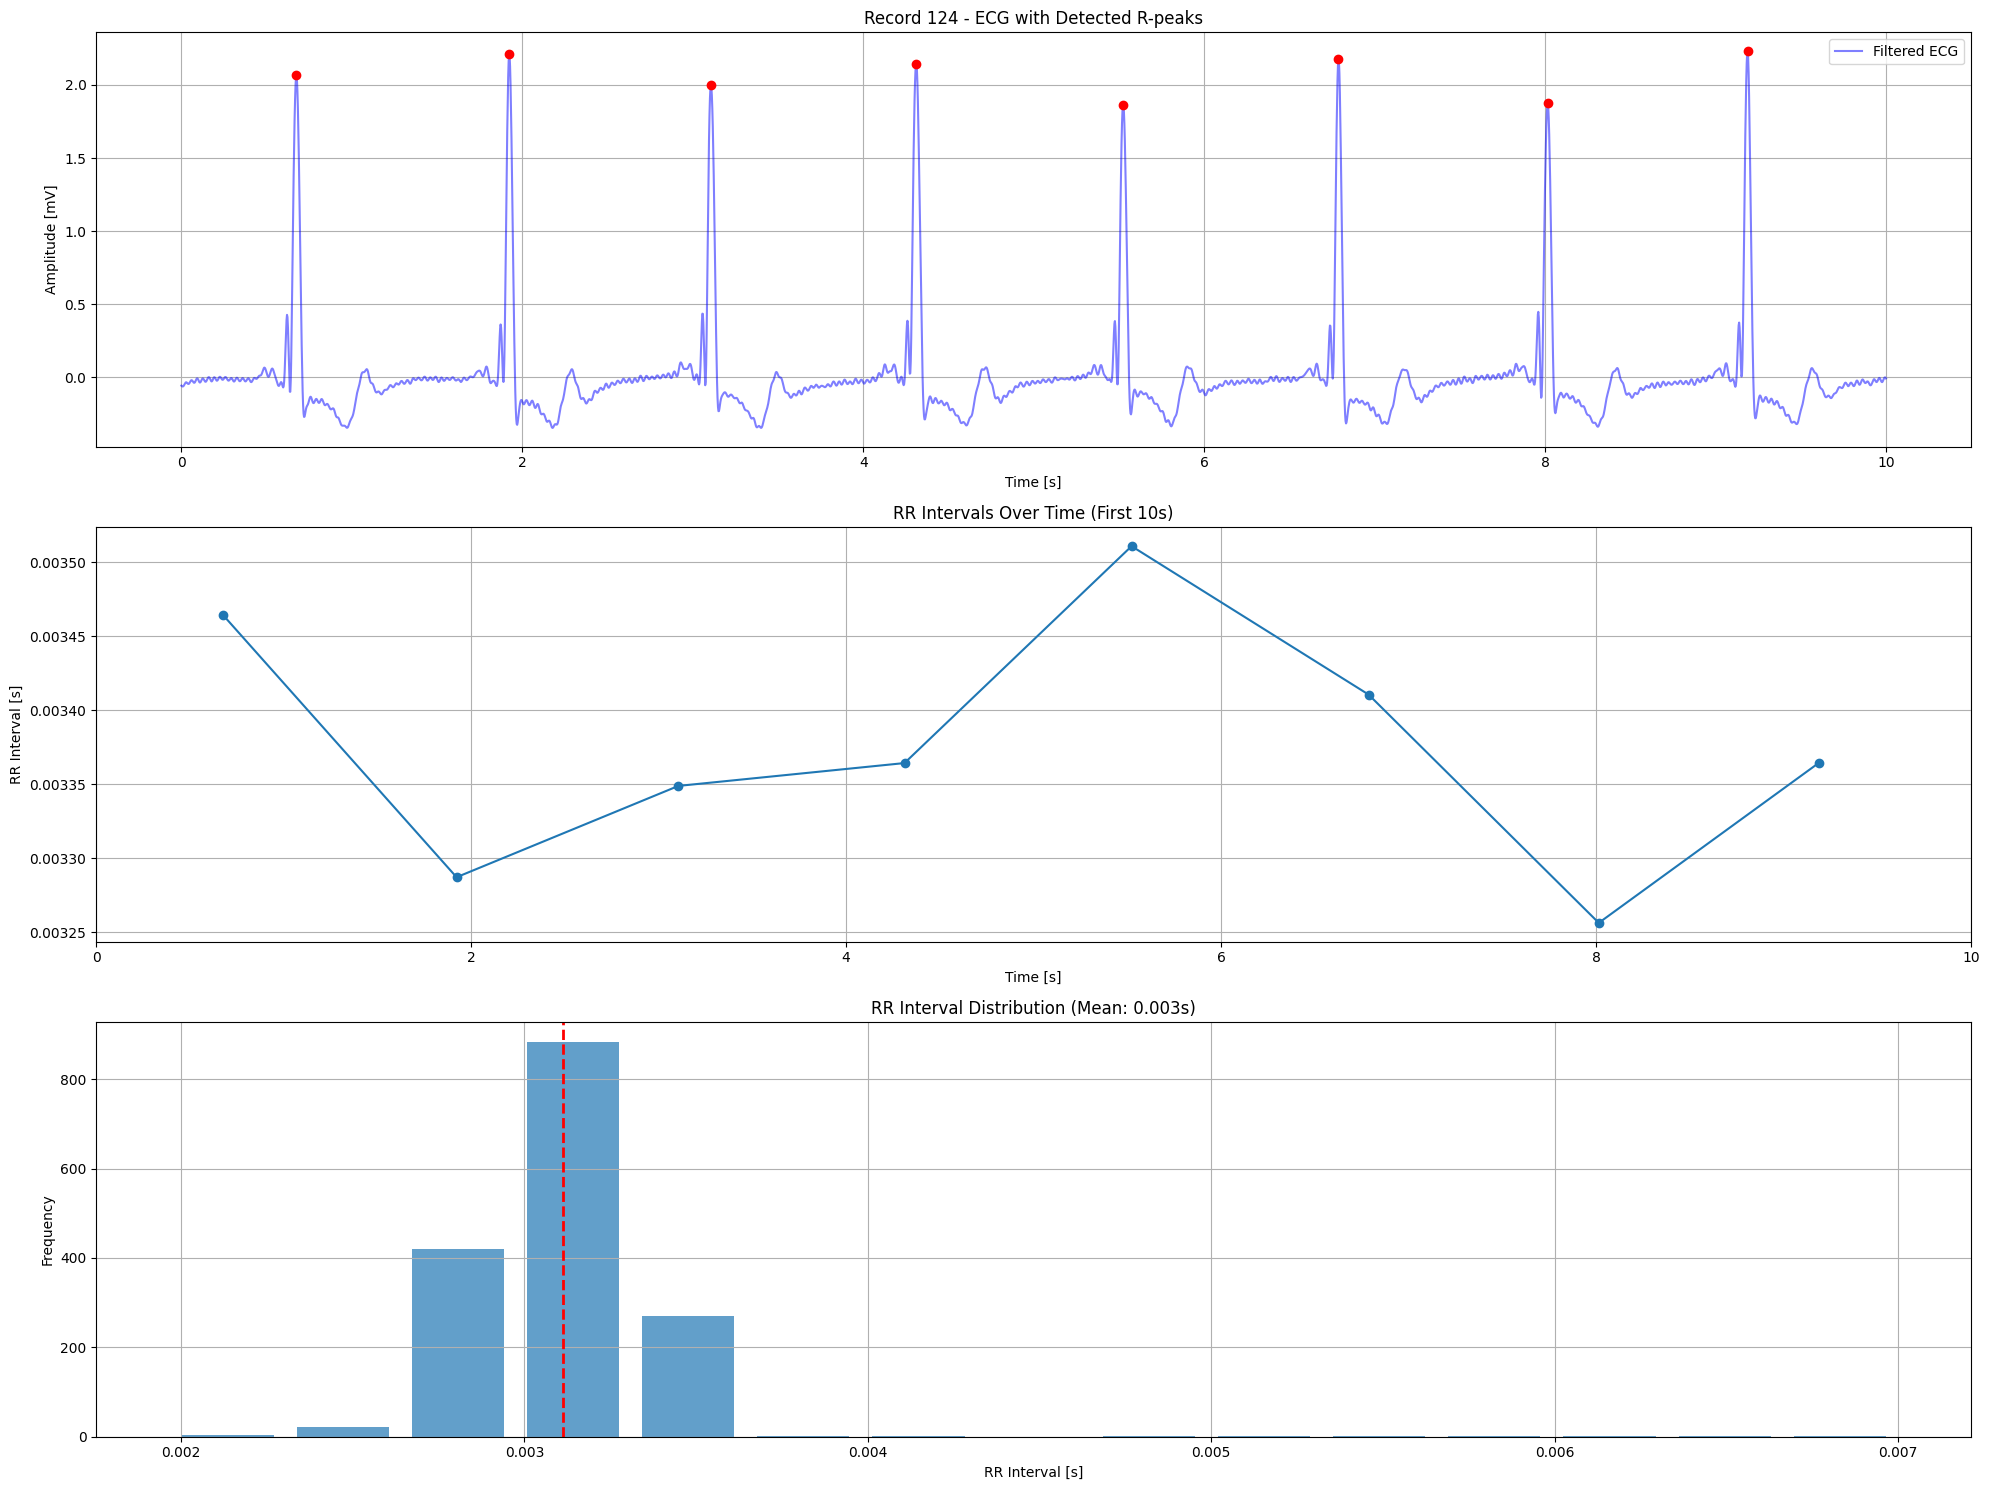

Heart Rate Analysis for Record 124:
- Average Heart Rate: 53.92 BPM
- Classification: Bradycardia (heart rate < 60 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0003 s
- RMSSD: 0.0003 s
- Mean RR Interval: 0.0031 s
- Min RR Interval: 0.0020 s
- Max RR Interval: 0.0070 s
- Heart Rate Standard Deviation: 4.33 BPM
- Heart Rate Min: 23.81 BPM
- Heart Rate Max: 84.71 BPM

----------------------------------------------------------------------
Processing R-peaks for record 201...


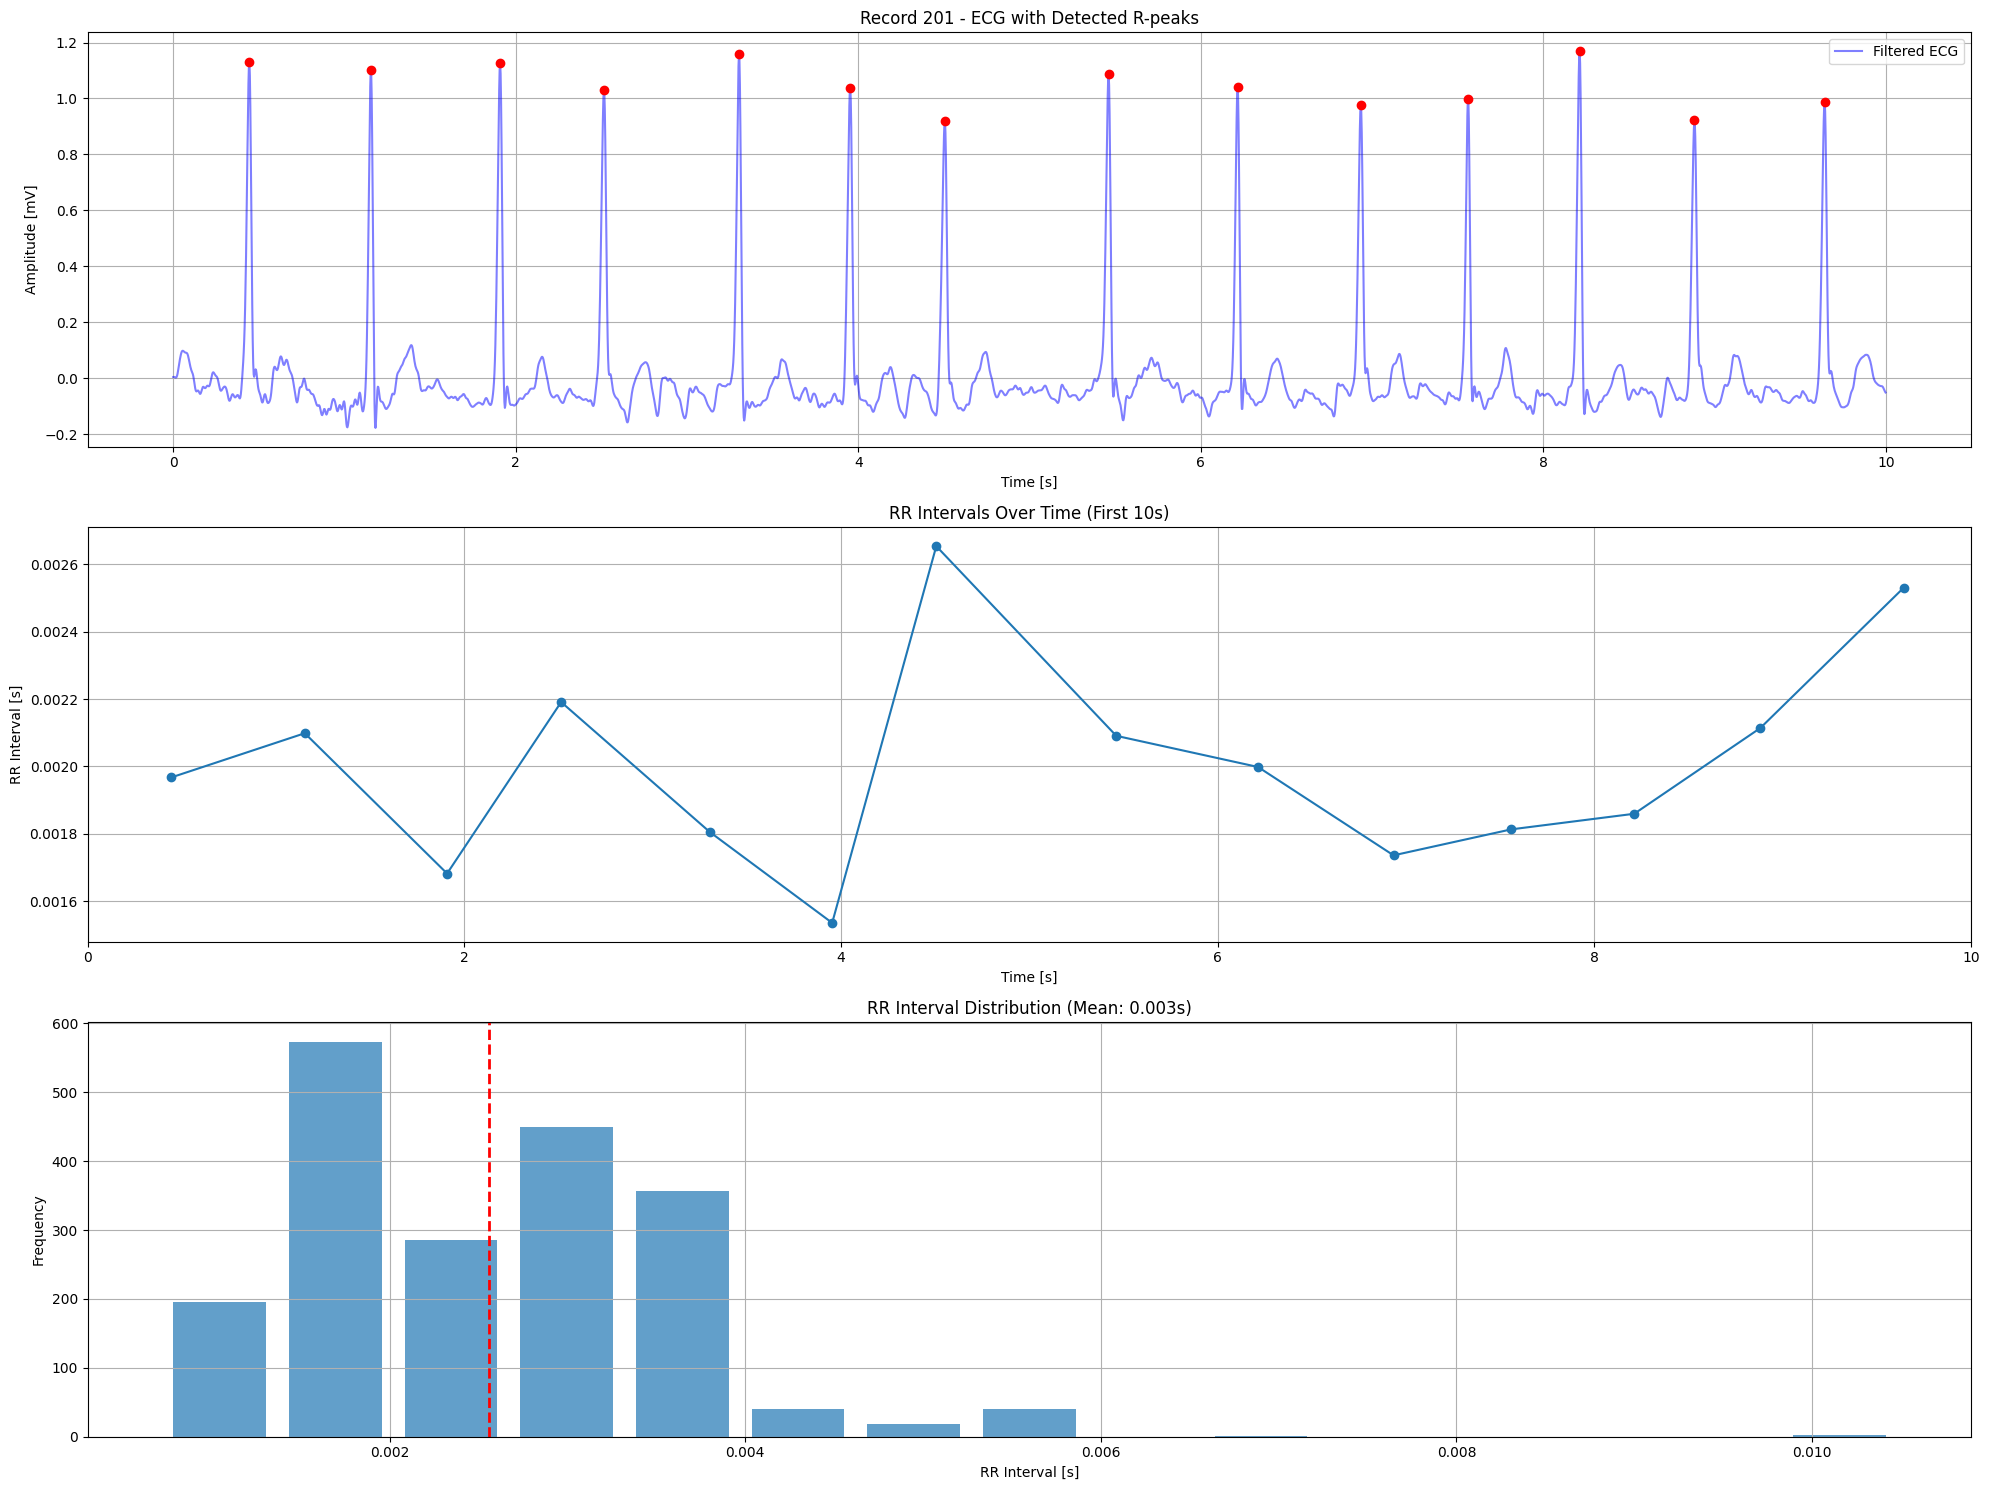

Heart Rate Analysis for Record 201:
- Average Heart Rate: 76.92 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0010 s
- RMSSD: 0.0011 s
- Mean RR Interval: 0.0026 s
- Min RR Interval: 0.0007 s
- Max RR Interval: 0.0105 s
- Heart Rate Standard Deviation: 33.49 BPM
- Heart Rate Min: 15.91 BPM
- Heart Rate Max: 232.26 BPM

----------------------------------------------------------------------
Processing R-peaks for record 210...


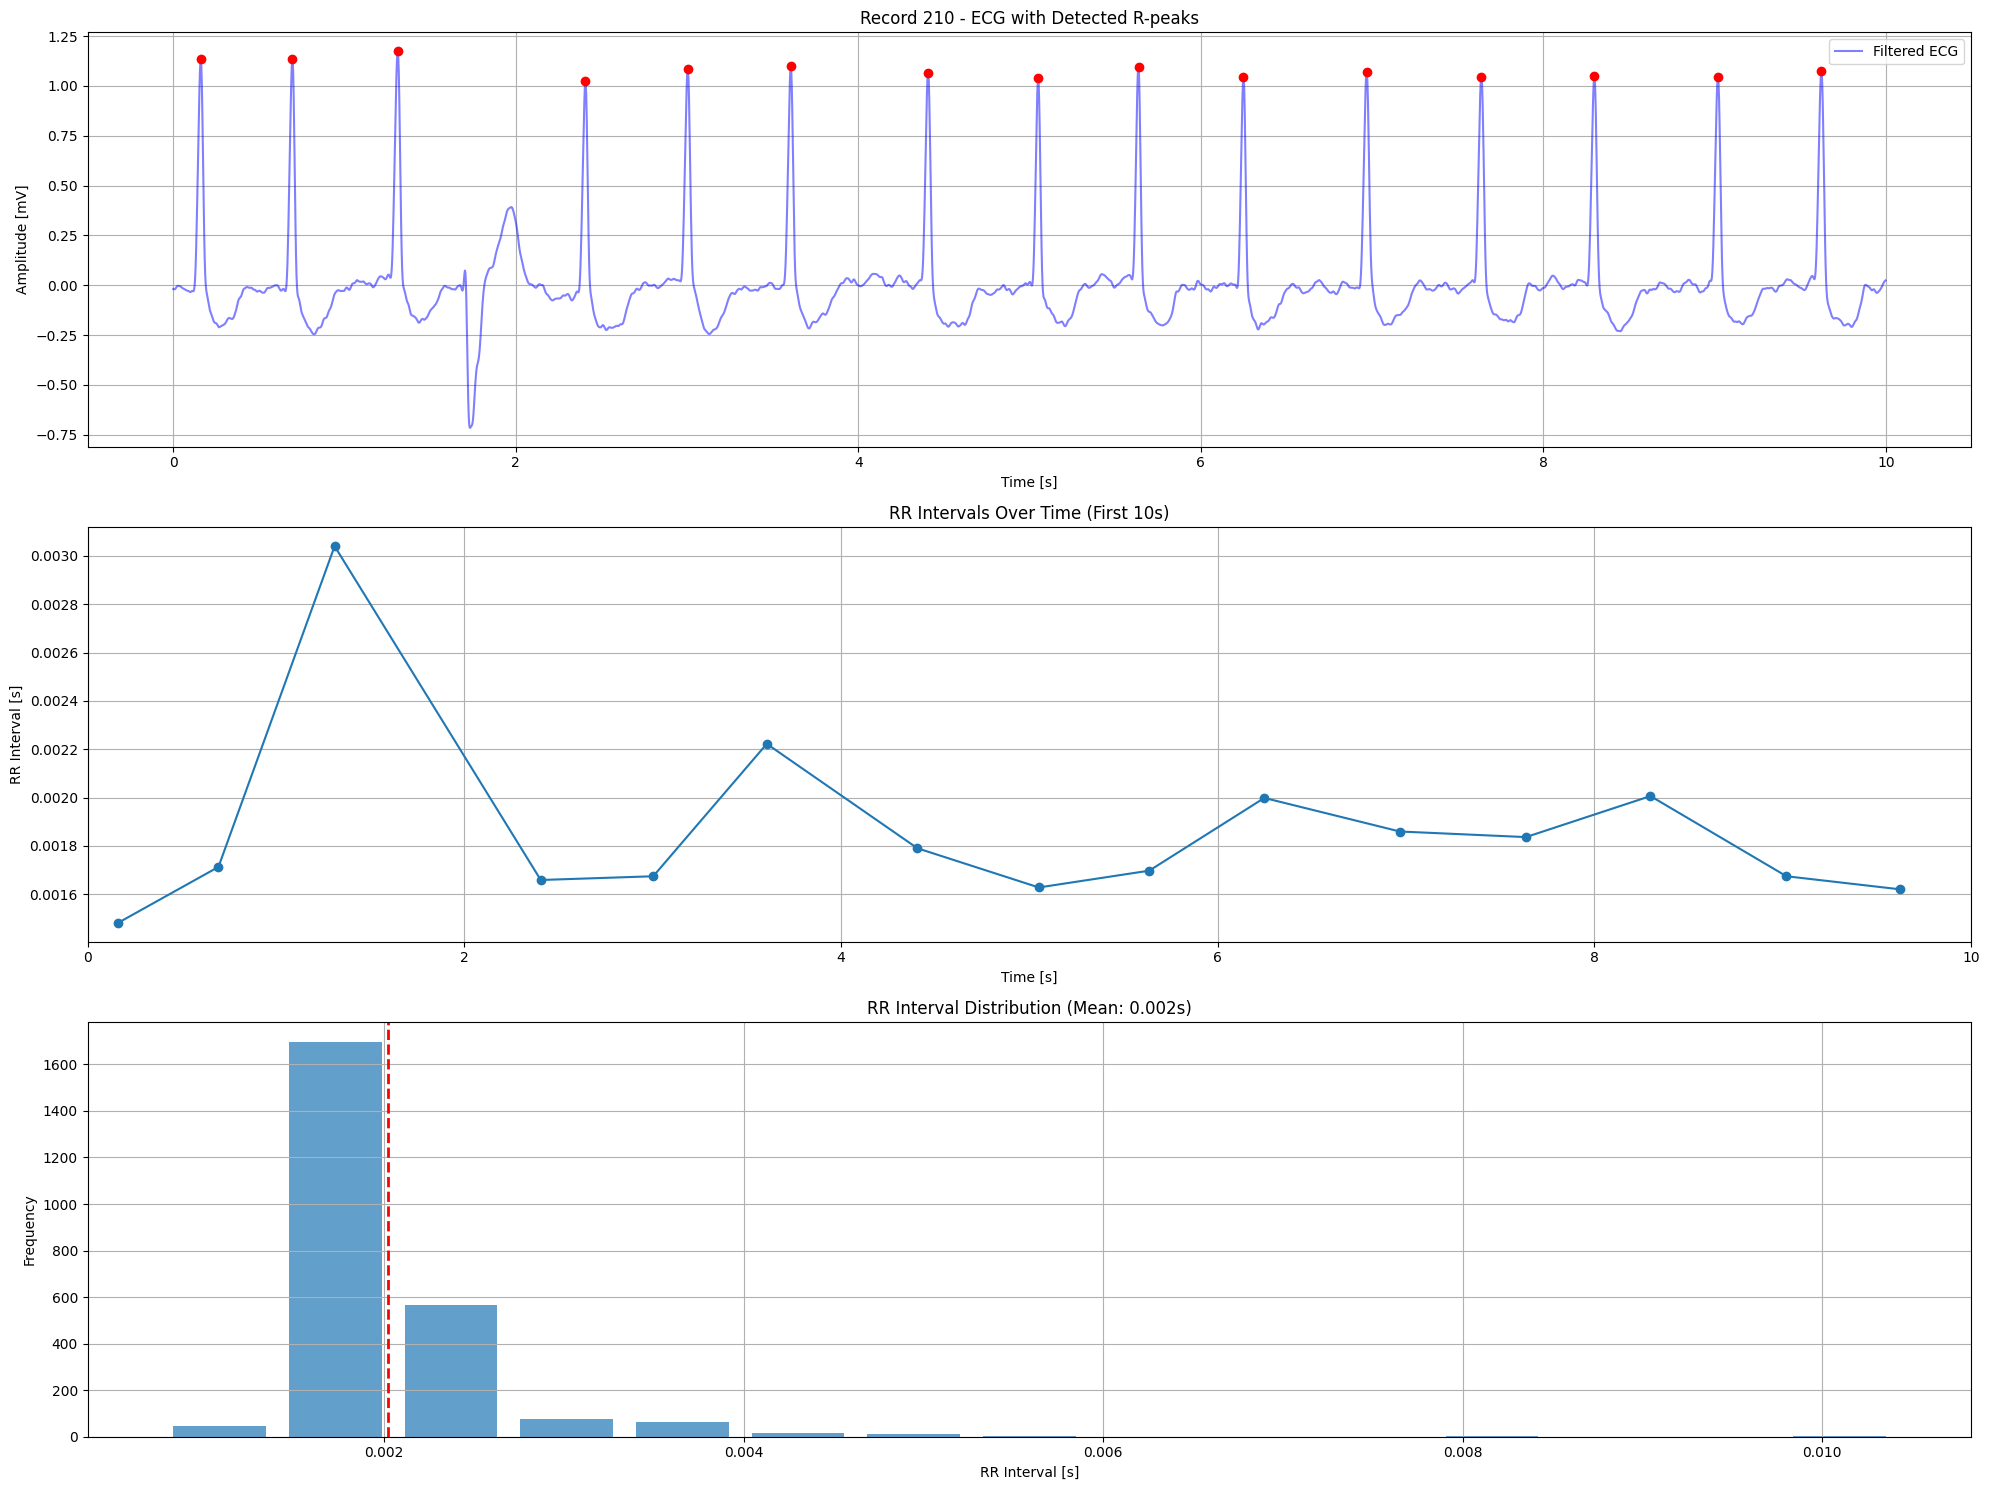

Heart Rate Analysis for Record 210:
- Average Heart Rate: 86.26 BPM
- Classification: Normal heart rate (60-100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0006 s
- RMSSD: 0.0008 s
- Mean RR Interval: 0.0020 s
- Min RR Interval: 0.0008 s
- Max RR Interval: 0.0104 s
- Heart Rate Standard Deviation: 16.18 BPM
- Heart Rate Min: 16.00 BPM
- Heart Rate Max: 218.18 BPM

----------------------------------------------------------------------
Processing R-peaks for record 217...


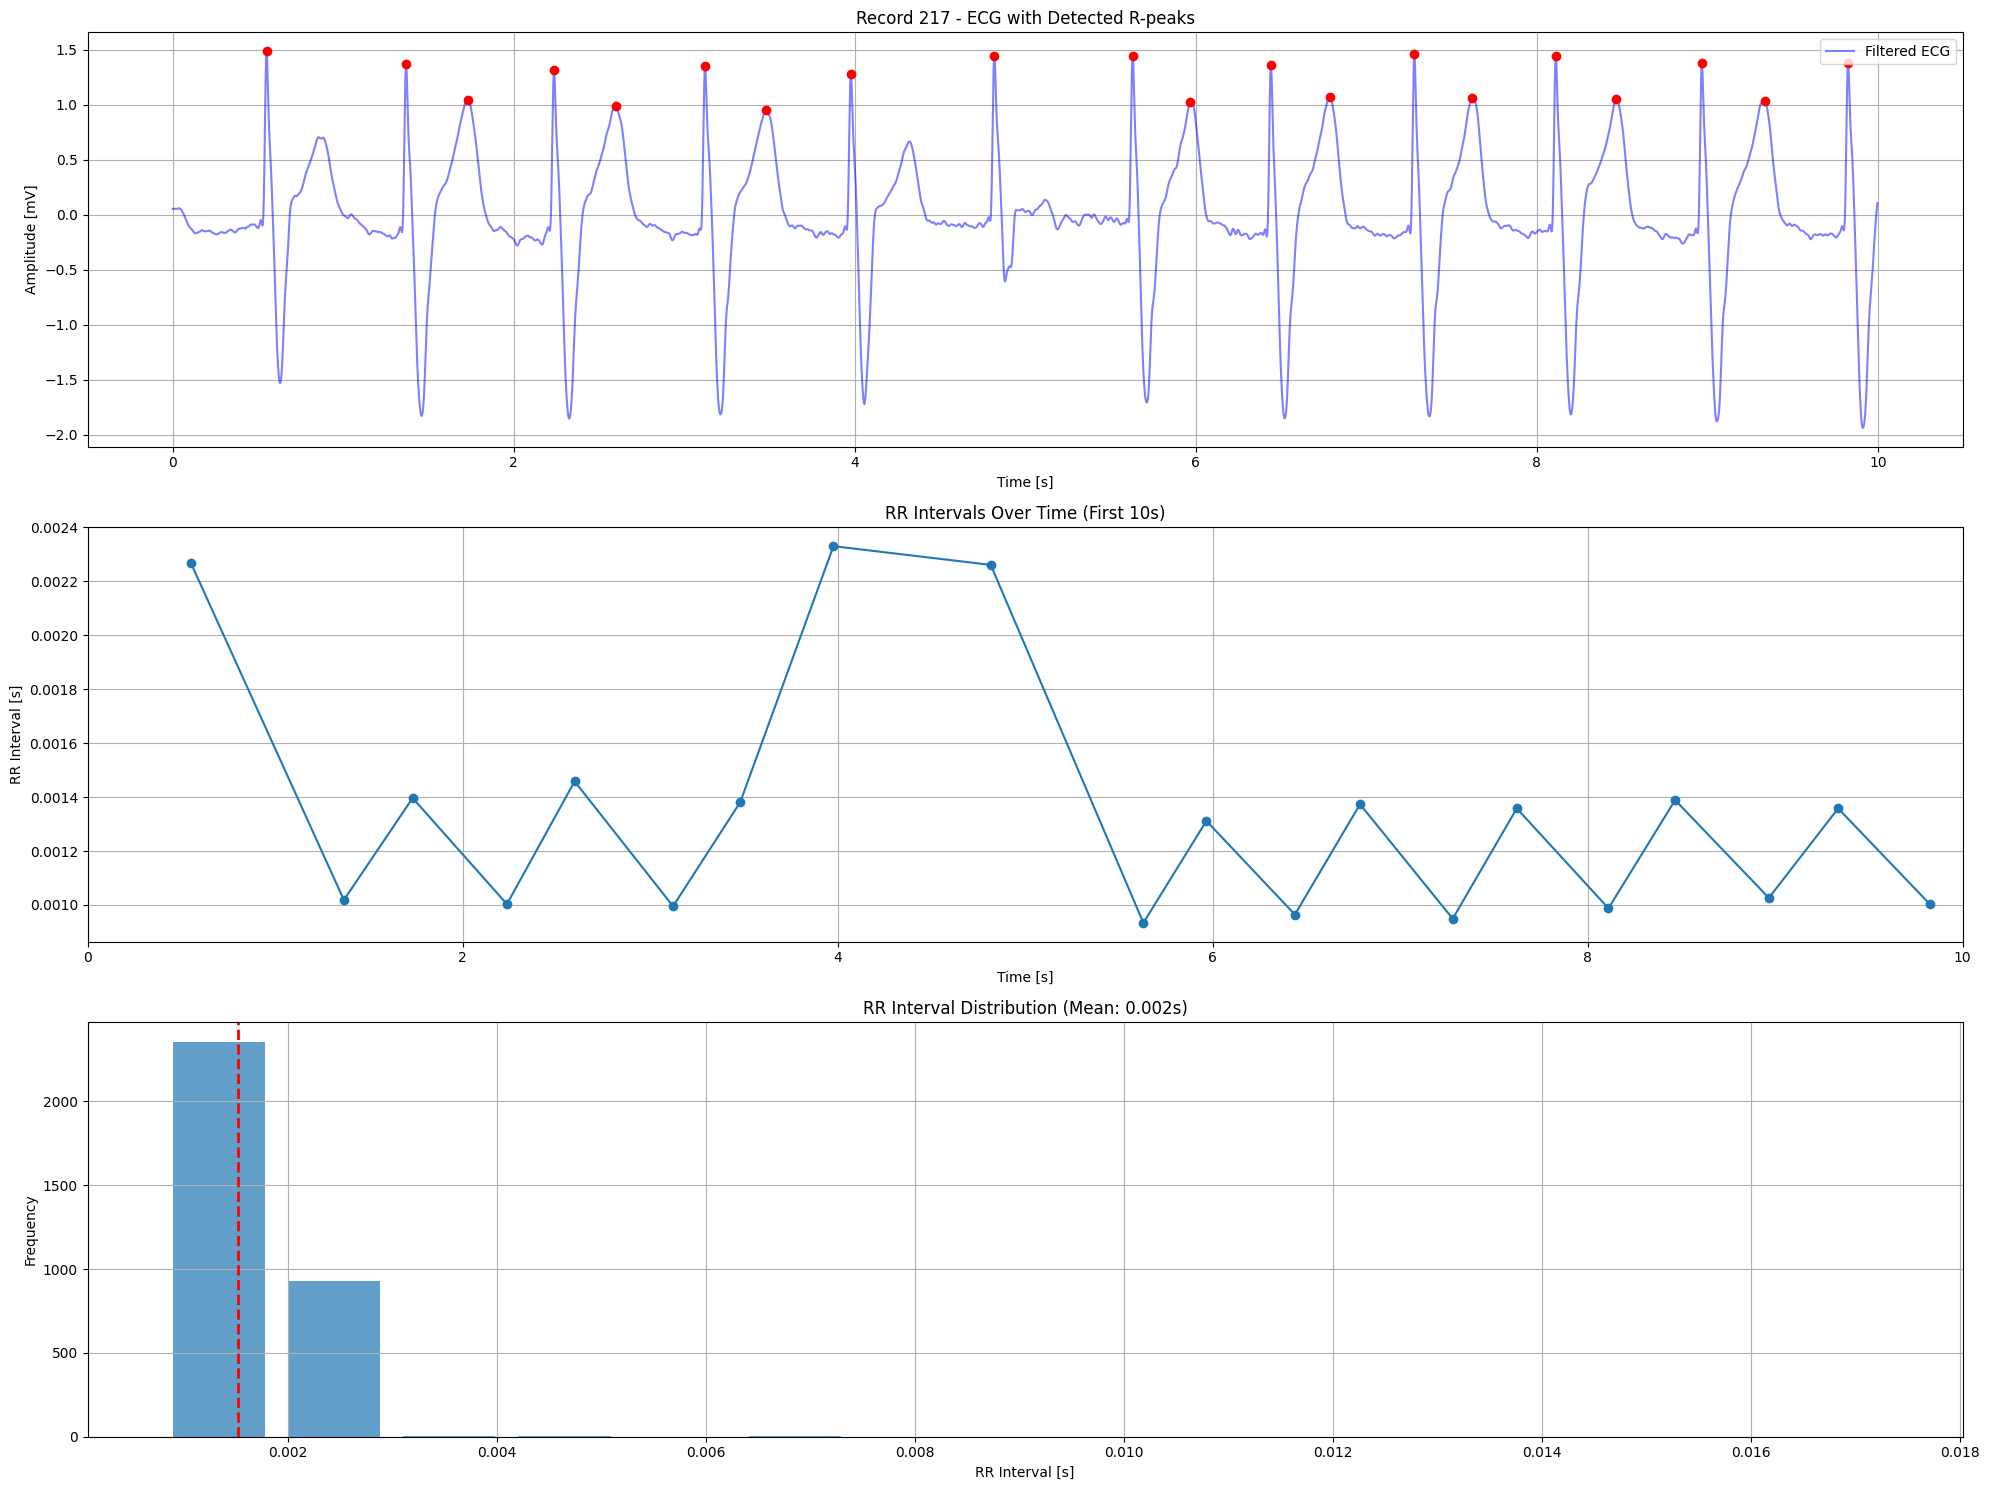

Heart Rate Analysis for Record 217:
- Average Heart Rate: 124.82 BPM
- Classification: Tachycardia (heart rate > 100 BPM)

Heart Rate Variability Metrics:
- SDNN: 0.0007 s
- RMSSD: 0.0008 s
- Mean RR Interval: 0.0015 s
- Min RR Interval: 0.0008 s
- Max RR Interval: 0.0173 s
- Heart Rate Standard Deviation: 40.89 BPM
- Heart Rate Min: 9.62 BPM
- Heart Rate Max: 211.76 BPM

----------------------------------------------------------------------
Section 3 completed for all records.


In [16]:
records = ['100', '101', '102', '103', '104', '105','108','114','118', '124', '201', '210' , '217'] #
# === Loop Through Each Record and Process Section 3 ===

duration_sec = 10
notch_freq = 50.0
band_low = 0.5
band_high = 40
all_SDNN=[]
for record_name in records:
    print(f"Processing R-peaks for record {record_name}...")
    record_path = f'mit-bih-arrhythmia-database-1.0.0/{record_name}'
    record = wfdb.rdrecord(record_path)
    fs = record.fs
    channels = record.sig_name
    channel_name = 'MLII' if 'MLII' in channels else channels[0]
    channel_index = channels.index(channel_name)

    # For plotting only
    start_sample = 0
    end_sample = int(duration_sec * fs)

    ecg_raw = record.p_signal[:, channel_index]
    t = np.arange(len(ecg_raw)) / fs

    # === Apply preprocessing to the complete signal ===
    ecg_no_baseline = remove_baseline_wander_fft(ecg_raw, fs)
    ecg_no_notch = apply_notch_filter(ecg_no_baseline, fs, notch_freq)
    ecg_filtered = bandpass_filter(ecg_no_notch, fs, band_low, band_high)

    # === Detect R-peaks on the entire signal ===
    r_peaks = detect_r_peaks(ecg_filtered, fs)
    if r_peaks.size == 0:
        print(f"No R-peaks detected in record {record_name}, trying lower threshold.")
        r_peaks = detect_r_peaks(ecg_filtered, fs, 0.1)
        if r_peaks.size == 0:
            print(f"No R-peaks detected in record {record_name} even with lower threshold.")
            continue

    # === Calculate RR intervals for entire signal ===
    rr_intervals = np.diff(r_peaks)/fs

    # === Calculate heart rate for entire signal ===
    avg_heart_rate, heart_rates, heart_rates_std, heart_rates_min, heart_rates_max = calculate_heart_rate(rr_intervals, fs)

    # === Analyze heart rate variability for entire signal ===
    hrv_metrics = analyze_heart_rate_variability(rr_intervals, fs)

    # === Create plot to visualize R-peaks and RR intervals (only duration_sec) ===
    plt.figure(figsize=(20, 15))

    # Plot ECG with R-peaks (only duration_sec)
    plt.subplot(3, 1, 1)
    plt.plot(t[start_sample:end_sample], ecg_filtered[start_sample:end_sample], label='Filtered ECG', color='blue', alpha=0.5)

    # Find R-peaks that fall within the plotting window
    r_peaks_in_window = r_peaks[r_peaks < end_sample]
    plt.plot(t[r_peaks_in_window], ecg_filtered[r_peaks_in_window], 'ro')

    plt.title(f"Record {record_name} - ECG with Detected R-peaks")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude [mV]")
    plt.grid()
    plt.legend(loc='upper right')

    # Plot RR intervals (only those within duration_sec)
    plt.subplot(3, 1, 2)
    # Find RR intervals where the first R-peak is within the plotting window
    rr_indices = np.where(r_peaks[:-1] < end_sample)[0]
    rr_times_plot = t[r_peaks[rr_indices]]
    rr_intervals_plot = rr_intervals[rr_indices]/fs

    plt.plot(rr_times_plot, rr_intervals_plot, 'o-')
    plt.title(f"RR Intervals Over Time (First {duration_sec}s)")
    plt.xlabel("Time [s]")
    plt.ylabel("RR Interval [s]")
    plt.xlim(0, duration_sec)
    plt.grid()

    # Plot RR interval histogram (using all intervals for better statistics)
    plt.subplot(3, 1, 3)
    plt.hist(rr_intervals/fs, bins=15, alpha=0.7, rwidth=0.8)
    plt.axvline(np.mean(rr_intervals/fs), color='r', linestyle='dashed', linewidth=2)
    plt.title(f"RR Interval Distribution (Mean: {np.mean(rr_intervals/fs):.3f}s)")
    plt.xlabel("RR Interval [s]")
    plt.ylabel("Frequency")
    plt.grid()

    plt.tight_layout()
    plt.show()

    plt.close()

    # === Report heart rate and HRV metrics ===
    print(f"Heart Rate Analysis for Record {record_name}:")
    print(f"- Average Heart Rate: {avg_heart_rate:.2f} BPM")

    # Classify heart rate
    if avg_heart_rate < 60:
        print("- Classification: Bradycardia (heart rate < 60 BPM)")
    elif avg_heart_rate > 100:
        print("- Classification: Tachycardia (heart rate > 100 BPM)")
    else:
        print("- Classification: Normal heart rate (60-100 BPM)")

    print("\nHeart Rate Variability Metrics:")
    print(f"- SDNN: {hrv_metrics['SDNN']:.4f} s")
    print(f"- RMSSD: {hrv_metrics['RMSSD']:.4f} s")
    print(f"- Mean RR Interval: {hrv_metrics['RR_mean']:.4f} s")
    print(f"- Min RR Interval: {hrv_metrics['RR_min']:.4f} s")
    print(f"- Max RR Interval: {hrv_metrics['RR_max']:.4f} s")
    print(f"- Heart Rate Standard Deviation: {heart_rates_std:.2f} BPM")
    print(f"- Heart Rate Min: {heart_rates_min:.2f} BPM")
    print(f"- Heart Rate Max: {heart_rates_max:.2f} BPM")
    # If SDNN is high, it may indicate arrhythmia
    if hrv_metrics['SDNN'] > 0.1:
        print("- Note: High RR interval variability might indicate arrhythmia.")
    print("\n" + "-"*70)
    all_SDNN.append(hrv_metrics['SDNN'])
print("Section 3 completed for all records.")

Section 4:


## Create csv file for all records as rows

In [17]:
import os

# Using os.path.exists to check if the file exists before attempting to remove it
file_path = 'mit-bih-arrhythmia-database-1.0.0/102-0.atr'
if os.path.exists(file_path):
	os.remove(file_path)
	print(f"File {file_path} has been removed")
else:
	print(f"File {file_path} does not exist")

File mit-bih-arrhythmia-database-1.0.0/102-0.atr has been removed


In [18]:
pip install glob2

In [19]:
import glob2
def get_records():
    """ Get paths for data in data/mit/ directory """
    # There are 3 files for each record
    # *.atr is one of them
    path_source = 'mit-bih-arrhythmia-database-1.0.0/*.atr'
    paths = glob2.glob(path_source)
    paths = [p.replace("\\", "/") for p in paths]

    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

# Check number of patients
records = get_records()

In [20]:
import scipy.stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Divide Records into Windows

In [27]:
# Create all 10 sec windows
import wfdb
# size in seconds of the truncated windows
windows_size_seconds = 10

# list of all windows and their corresponding annotations
all_windows = []
all_annot = []
all_records = [record.split('/')[-1] for record in records]
# read MITBIH database and generate all 10sec samples
for f in all_records:
        f_records = []
        f_annot = []
        record_nb = str(f[:3])
        record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/' + record_nb)
        sig_len = record.sig_len
        annotation = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/' + record_nb, 'atr')
        windows_size = windows_size_seconds * record.fs
        #windows_nb = sig_len // windows_size
        i=0
        for w in range(0, sig_len-windows_size, windows_size):
            i += 1
            f_records.append(wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/' + record_nb, sampfrom=w, sampto=w+windows_size))
            temp_annot = wfdb.rdann('mit-bih-arrhythmia-database-1.0.0/' + record_nb, 'atr', sampfrom=w, sampto=w+windows_size)
            # move annot to 0: -1 because annotations started at 1 (python array start at 0)
            temp_annot.sample -= (w + 1)
            f_annot.append(temp_annot)
        all_windows.append(f_records)
        all_annot.append(f_annot)
        print(record_nb, f"processed and subdivided into {i} windows")

100 processed and subdivided into 180 windows
101 processed and subdivided into 180 windows
102 processed and subdivided into 180 windows
103 processed and subdivided into 180 windows
104 processed and subdivided into 180 windows
105 processed and subdivided into 180 windows
106 processed and subdivided into 180 windows
107 processed and subdivided into 180 windows
108 processed and subdivided into 180 windows
109 processed and subdivided into 180 windows
111 processed and subdivided into 180 windows
112 processed and subdivided into 180 windows
113 processed and subdivided into 180 windows
114 processed and subdivided into 180 windows
115 processed and subdivided into 180 windows
116 processed and subdivided into 180 windows
117 processed and subdivided into 180 windows
118 processed and subdivided into 180 windows
119 processed and subdivided into 180 windows
121 processed and subdivided into 180 windows
122 processed and subdivided into 180 windows
123 processed and subdivided into 

In [28]:
patients_id = []

for f in all_records:
    record_nb = str(f[:3])
    patients_id.append(int(f[:3]))


In [30]:
# Define the records to be included

all_avg_heart_rates = []
all_rr_intervals = []
all_heart_rates = []
all_heart_rates_std = []
all_heart_rates_min = []
all_heart_rates_max = []
all_SDNN = []

for patient in range(len(all_windows)):
    for w in range(len(all_windows[patient])):
        index = str(patients_id[patient]) + '_' + str(w)
        record = all_windows[patient][w]
        signal = record.p_signal[:, 0]
        annotation = all_annot[patient][w]
        sig_at_annot = signal[annotation.sample]
        fs = record.fs
        channels = record.sig_name
        channel_name = 'MLII' if 'MLII' in channels else channels[0]
        channel_index = channels.index(channel_name)

        # For plotting only
        start_sample = 0
        end_sample = int(duration_sec * fs)

        ecg_raw = record.p_signal[:, channel_index]
        t = np.arange(len(ecg_raw)) / fs

        # === Apply preprocessing to the complete signal ===
        ecg_no_baseline = remove_baseline_wander_fft(ecg_raw, fs)
        ecg_no_notch = apply_notch_filter(ecg_no_baseline, fs, notch_freq)
        ecg_filtered = bandpass_filter(ecg_no_notch, fs, band_low, band_high)

        # === Detect R-peaks on the entire signal ===
        r_peaks = detect_r_peaks(ecg_filtered, fs)

        if r_peaks.size == 0 or r_peaks.size == 1:
            print(f"No R-peaks detected in record {index}, trying lower threshold.")
            r_peaks = detect_r_peaks(ecg_filtered, fs, 0.1)
            if r_peaks.size ==  0 or r_peaks.size == 1:
                print(f"No R-peaks detected in record {index} even with lower threshold.")
                r_peaks = detect_r_peaks(ecg_filtered, fs, 0.05)


        # === Calculate RR intervals for entire signal ===
        rr_intervals = np.diff(r_peaks)/fs

        # === Calculate heart rate for entire signal ===
        avg_heart_rate, heart_rates, heart_rates_std, heart_rates_min, heart_rates_max = calculate_heart_rate(rr_intervals, fs)
        all_avg_heart_rates.append(avg_heart_rate)
        all_rr_intervals.append(np.mean(rr_intervals))
        all_heart_rates.append(np.mean(heart_rates))
        all_heart_rates_std.append(heart_rates_std)
        all_heart_rates_min.append(heart_rates_min)
        all_heart_rates_max.append(heart_rates_max)
        # === Analyze heart rate variability for entire signal ===

        # === Analyze heart rate variability for entire signal ===
        hrv_metrics = analyze_heart_rate_variability(rr_intervals, fs)
        all_SDNN.append(hrv_metrics['SDNN'])

No R-peaks detected in record 108_3, trying lower threshold.
No R-peaks detected in record 207_41, trying lower threshold.
No R-peaks detected in record 207_44, trying lower threshold.
No R-peaks detected in record 228_5, trying lower threshold.
No R-peaks detected in record 228_6, trying lower threshold.
No R-peaks detected in record 228_8, trying lower threshold.


In [31]:
# Number of generated samples
print('number of patients:', len(all_windows))
print('number of windows per patient:', len(all_windows[0]))
print('total number of windows:', len(all_windows) * len(all_windows[0]))

number of patients: 48
number of windows per patient: 180
total number of windows: 8640


In [32]:
def plot_single_window(index, copy=True):
    patient = int(str(index)[:3])
    window = int(str(index)[3:7])
    record = all_windows[patients_id.index(patient)][window]
    annotation = all_annot[patients_id.index(patient)][window]
    wfdb.plot_items(signal = record.p_signal,
                ann_samp = [annotation.sample, annotation.sample],
                ann_sym = [annotation.symbol, annotation.symbol],
                title = 'Record %s from MIT-BIH Arrhythmia Database' % record.record_name,
                fs = record.fs,
                time_units = 'seconds',
                figsize = (20,9)
                )

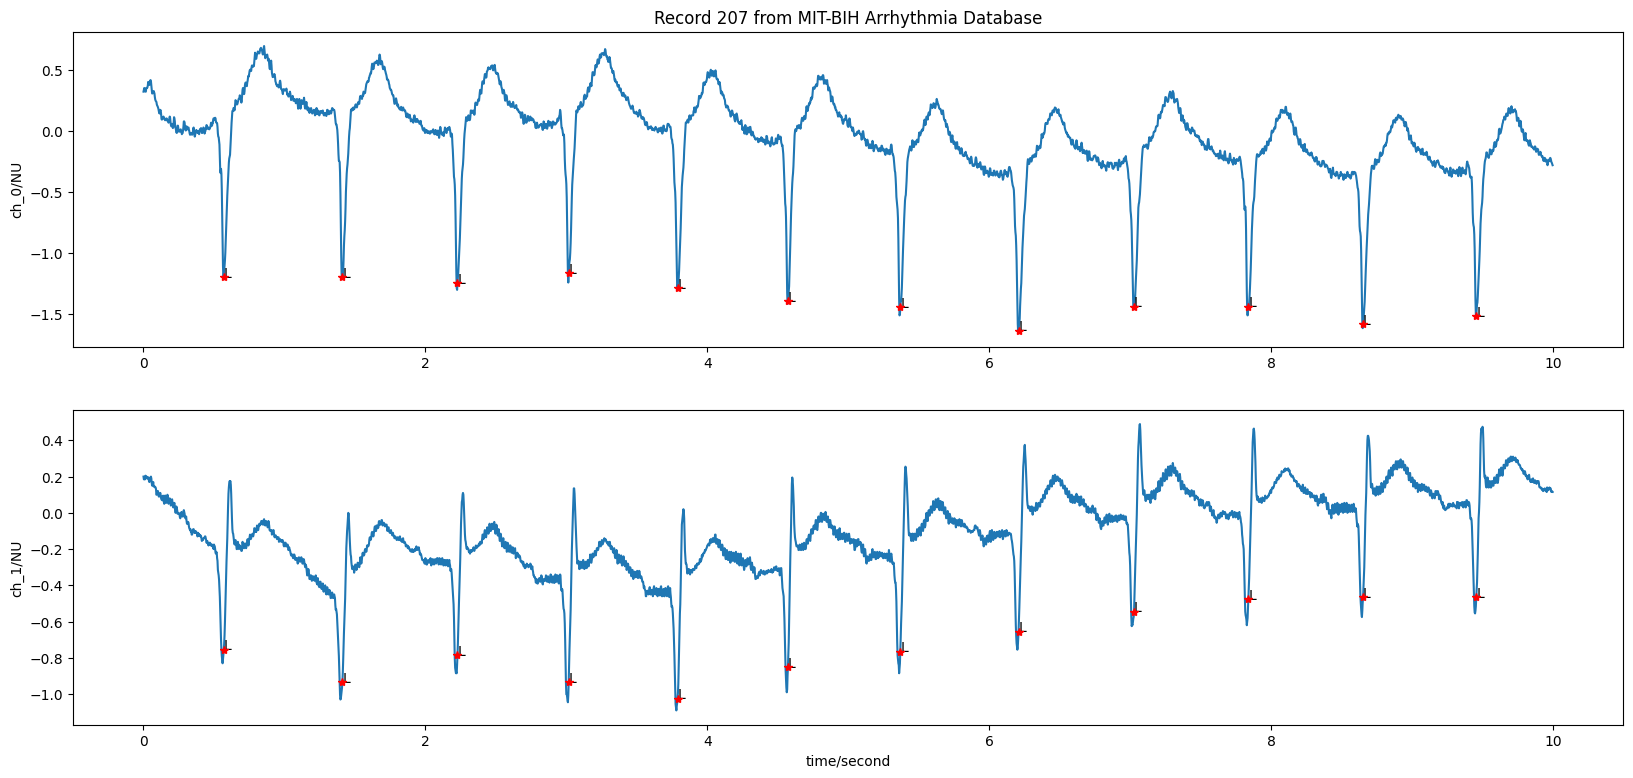

In [33]:
plot_single_window(207_39)  #can go from _0 to _179

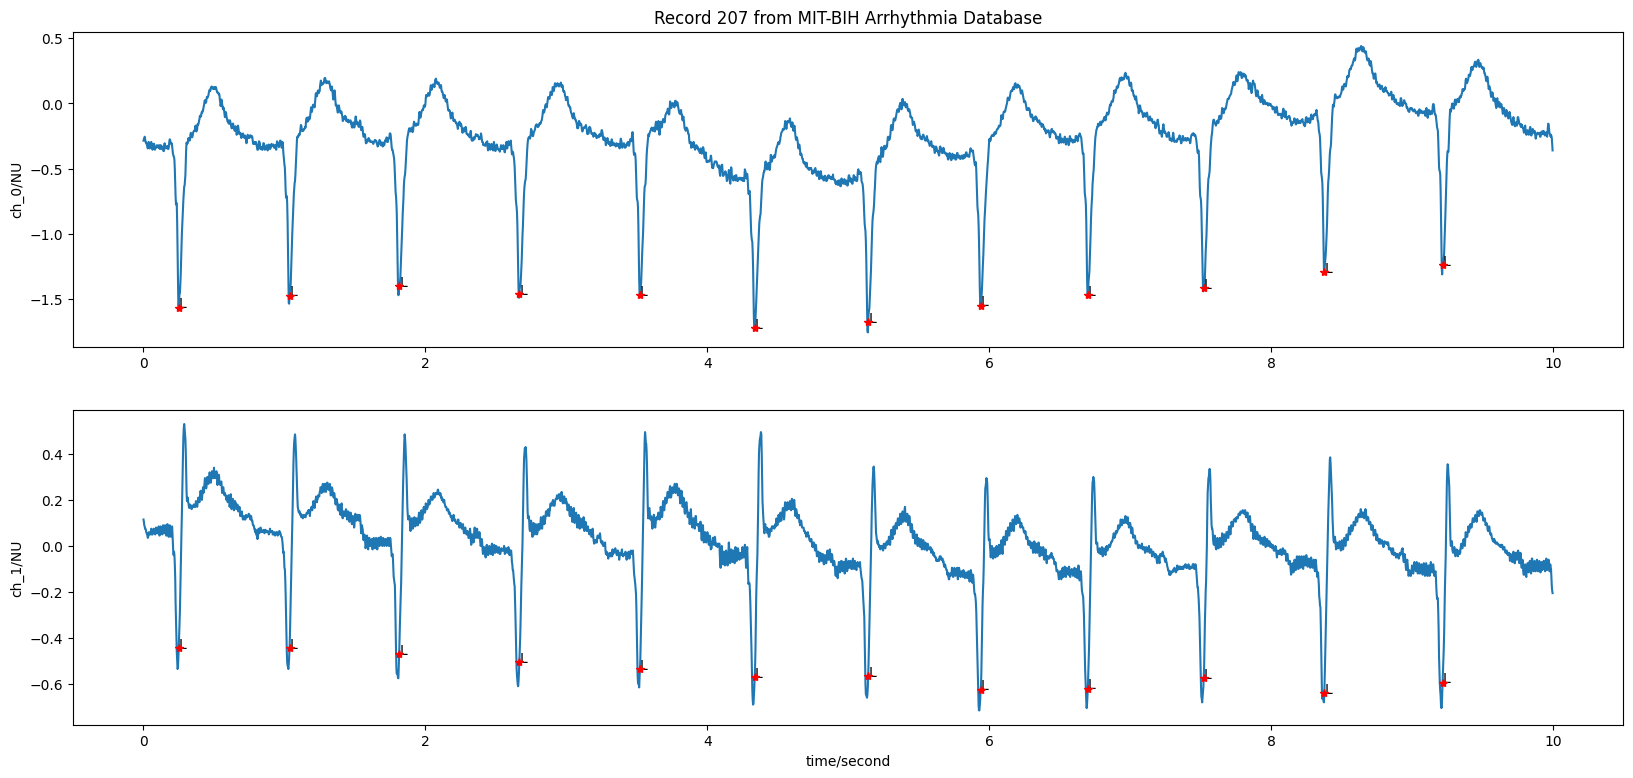

In [34]:
plot_single_window(207_40)  #can go from _0 to _179

In [35]:
patients_id[0:5]

[100, 101, 102, 103, 104]

## Feature Extraction

In [36]:
# Create an array of indices in the format 'patient_id_window_number'
indices = [str(patients_id[patient]) + '_' + str(w) for patient in range(len(all_windows)) for w in range(len(all_windows[patient]))]
indices[0:5]
len(indices)

8640

In [37]:
age_arr =[]
gender_arr = []
Signal_Max = []
Signal_Min = []
Signal_Mean = []
N_counts = []
abnormal = []
Outliers_Peak2Peak_1 = []
Outliers_Peak2Peak_2 = []
for patient in range(len(all_windows)):
    for w in range(len(all_windows[patient])):
        index = str(patients_id[patient]) + '_' + str(w)
        record = all_windows[patient][w]
        signal = record.p_signal[:, 0]
        annotation = all_annot[patient][w]

        age_arr.append(record.comments[0][:2])
        gender_arr.append(record.comments[0][3])

        Signal_Max.append(np.max(signal))
        Signal_Min.append(np.min(signal))
        Signal_Mean.append(np.mean(signal))

        N_counts.append(annotation.symbol.count('N'))
        abnormal.append(int(annotation.symbol.count('V') > 0))

        dist_btw_annot = (annotation.sample[1:] - annotation.sample[:-1]) / record.fs
        Outliers_Peak2Peak_1.append(int(max(dist_btw_annot > np.mean(dist_btw_annot) + 2*np.std(dist_btw_annot))))
        Outliers_Peak2Peak_2.append(max(dist_btw_annot - np.mean(dist_btw_annot)))



In [38]:
print(len(all_records))
print(len(all_avg_heart_rates))
print(len(all_rr_intervals))
print(len(all_heart_rates))
print(len(all_heart_rates_std))
print(len(all_heart_rates_min))
print(len(all_heart_rates_max))
print(len(all_avg_heart_rates))
print("")
print(len(age_arr))
print(len(gender_arr))
print(len(Signal_Max))
print(len(Signal_Min))
print(len(Signal_Mean))
print(len(N_counts))
print(len(abnormal))
print(len(Outliers_Peak2Peak_1))
print(len(Outliers_Peak2Peak_2))

print(len(patients_id))

48
8640
8640
8640
8640
8640
8640
8640

8640
8640
8640
8640
8640
8640
8640
8640
8640
48


In [39]:
ID_patient = [int(indices.split('_')[0]) for indices in indices]
print(len(ID_patient))
ID_sample = [int(indices.split('_')[1]) for indices in indices]
print(len(ID_sample))

8640
8640


In [40]:
data = {
    'index': indices,
    'ID_patient': ID_patient,
    'ID_sample' : ID_sample,
    'Age': age_arr,
    'Gender': gender_arr,
    'Signal_Max':Signal_Max,
    'Signal_Min':Signal_Min,
    'Signal_Mean':Signal_Mean,
    'Avg_Heart_Rate': all_avg_heart_rates,
    'RR_Interval': all_rr_intervals,
    'Outliers_Peak2Peak_1': Outliers_Peak2Peak_1,
    'Outliers_Peak2Peak_2': Outliers_Peak2Peak_2,
    'SDNN': all_SDNN,
    'N': N_counts,
    'Abnormal': abnormal
}

In [41]:
# Build the dataset
df_windows = pd.DataFrame(data, index=indices)
df_windows = df_windows.drop(columns=['index'])


In [42]:
df_windows.columns

Index(['ID_patient', 'ID_sample', 'Age', 'Gender', 'Signal_Max', 'Signal_Min',
       'Signal_Mean', 'Avg_Heart_Rate', 'RR_Interval', 'Outliers_Peak2Peak_1',
       'Outliers_Peak2Peak_2', 'SDNN', 'N', 'Abnormal'],
      dtype='object')

In [43]:
df_windows.head()

ID_patient  ID_sample Age Gender  Signal_Max  Signal_Min  Signal_Mean  \
100_0         100          0  69      M       0.960      -0.645    -0.319922   
100_1         100          1  69      M       0.975      -0.585    -0.318408   
100_2         100          2  69      M       1.050      -0.680    -0.367768   
100_3         100          3  69      M       1.050      -0.695    -0.368653   
100_4         100          4  69      M       1.020      -0.640    -0.344692   

       Avg_Heart_Rate  RR_Interval  Outliers_Peak2Peak_1  \
100_0       75.035671     0.806019                     0   
100_1       73.310952     0.819192                     1   
100_2       74.352015     0.807828                     0   
100_3       73.485678     0.817424                     1   
100_4       73.571970     0.815972                     0   

       Outliers_Peak2Peak_2      SDNN   N  Abnormal  
100_0              0.237607  0.000203  12         0  
100_1              0.050253  0.000070  12         0  
100_2              0.050253  0.000073  12         0  
100_3              0.063131  0.000078  12         0  
100_4              0.025926  0.000053  13         0

In [44]:
df_windows['Gender'].replace(['M', 'F'], [0, 1], inplace=True);

<ipython-input-44-698039ac09f7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_windows['Gender'].replace(['M', 'F'], [0, 1], inplace=True);
<ipython-input-44-698039ac09f7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_windows['Gender'].replace(['M', 'F'], [0, 1], inplace=True);


In [64]:
df_windows.head(10)

ID_patient  ID_sample Age  Gender  Signal_Max  Signal_Min  Signal_Mean  \
100_0         100          0  69       0       0.960      -0.645    -0.319922   
100_1         100          1  69       0       0.975      -0.585    -0.318408   
100_2         100          2  69       0       1.050      -0.680    -0.367768   
100_3         100          3  69       0       1.050      -0.695    -0.368653   
100_4         100          4  69       0       1.020      -0.640    -0.344692   
100_5         100          5  69       0       1.030      -0.650    -0.298644   
100_6         100          6  69       0       1.120      -0.590    -0.281268   
100_7         100          7  69       0       0.960      -0.655    -0.329631   
100_8         100          8  69       0       1.035      -0.670    -0.314265   
100_9         100          9  69       0       1.125      -0.650    -0.313326   

       Avg_Heart_Rate  RR_Interval  Outliers_Peak2Peak_1  \
100_0       75.035671     0.806019                     0   
100_1       73.310952     0.819192                     1   
100_2       74.352015     0.807828                     0   
100_3       73.485678     0.817424                     1   
100_4       73.571970     0.815972                     0   
100_5       74.411258     0.807071                     0   
100_6       74.679505     0.804040                     0   
100_7       73.358637     0.818434                     0   
100_8       74.079800     0.810606                     1   
100_9       74.170890     0.809596                     0   

       Outliers_Peak2Peak_2      SDNN   N  Abnormal  
100_0              0.237607  0.000203  12         0  
100_1              0.050253  0.000070  12         0  
100_2              0.050253  0.000073  12         0  
100_3              0.063131  0.000078  12         0  
100_4              0.025926  0.000053  13         0  
100_5              0.048485  0.000069  12         0  
100_6              0.038889  0.000061  13         0  
100_7              0.039646  0.000058  12         0  
100_8              0.047727  0.000065  12         0  
100_9              0.042929  0.000064  12         0

In [66]:
df_windows['Abnormal'].value_counts()


Abnormal
0    6258
1    2382
Name: count, dtype: int64

In [ ]:
df_windows.describe()

ID_patient   ID_sample       Gender   Signal_Max   Signal_Min  \
count  8640.000000  8640.00000  8640.000000  8640.000000  8640.000000   
mean    166.229167    89.50000     0.458333     1.435388    -1.280074   
std      53.064058    51.96373     0.498290     0.654583     0.660104   
min     100.000000     0.00000     0.000000    -0.345000    -5.120000   
25%     112.750000    44.75000     0.000000     0.970000    -1.750000   
50%     200.500000    89.50000     0.000000     1.475000    -1.100000   
75%     215.500000   134.25000     1.000000     1.905000    -0.725000   
max     234.000000   179.00000     1.000000     5.115000    -0.225000   

       Signal_Mean  Avg_Heart_Rate  RR_Interval  Outliers_Peak2Peak_1  \
count  8640.000000     8640.000000  8640.000000           8640.000000   
mean     -0.338627       89.167194     0.770999              0.261343   
std       0.275774       26.934952     0.228277              0.439392   
min      -1.903068       16.011861     0.302257              0.000000   
25%      -0.481237       70.741746     0.630324              0.000000   
50%      -0.222274       84.046517     0.733796              0.000000   
75%      -0.154829      103.373471     0.879352              1.000000   
max       0.241932      206.063811     4.108333              1.000000   

       Outliers_Peak2Peak_2         SDNN            N     Abnormal  
count           8640.000000  8640.000000  8640.000000  8640.000000  
mean               0.169904     0.000323     8.660069     0.275694  
std                0.233928     0.000394     5.650678     0.446889  
min                0.004365     0.000000     0.000000     0.000000  
25%                0.038889     0.000071     2.000000     0.000000  
50%                0.078308     0.000197    10.000000     0.000000  
75%                0.231313     0.000470    13.000000     1.000000  
max                4.009444     0.008759    23.000000     1.000000

In [157]:
df_windows[['ID_patient', 'Abnormal']].groupby('ID_patient').sum() > 0;

In [158]:
df_windows.shape

(8640, 14)

In [159]:
from sklearn.utils import resample

def stratified_split_balanced(df, target_column, test_size=0.2, random_state=None):
    """
    Performs a stratified train-test split with class balancing via undersampling.
    """
    # Separate features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Combine X and y for resampling
    df_full = pd.concat([X, y], axis=1)

    # Separate majority and minority classes
    df_majority = df_full[df_full[target_column] == 0]
    df_minority = df_full[df_full[target_column] == 1]

    # Undersample majority class to match minority class size
    df_majority_undersampled = resample(
        df_majority, replace=False, n_samples=len(df_minority), random_state=random_state
    )

    # Combine balanced data
    df_balanced = pd.concat([df_majority_undersampled, df_minority])

    # Split features and target again
    X_balanced = df_balanced.drop(target_column, axis=1)
    y_balanced = df_balanced[target_column]

    # Perform stratified train-test split on balanced data
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced, y_balanced, test_size=test_size, random_state=random_state, stratify=y_balanced
    )

    return X_train, X_test, y_train, y_test

# Example usage
X_train, X_test, y_train, y_test = stratified_split_balanced(
    df_windows, target_column='Abnormal', test_size=0.2, random_state=42
)

# Verify shapes and distributions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nDistribution of 'Abnormal' in y_train (counts):")
print(y_train.value_counts())
print("\nDistribution of 'Abnormal' in y_test (counts):")
print(y_test.value_counts())

X_train shape: (3811, 13)
X_test shape: (953, 13)
y_train shape: (3811,)
y_test shape: (953,)

Distribution of 'Abnormal' in y_train (counts):
Abnormal
1    1906
0    1905
Name: count, dtype: int64

Distribution of 'Abnormal' in y_test (counts):
Abnormal
0    477
1    476
Name: count, dtype: int64


In [160]:
# Sanity check
print('Check dimensions:')
print('(x_train)', X_train.shape)
print('(x_test)', X_test.shape)
print('(y_train)', y_train.shape)
print('(y_test)', y_test.shape)
print('Train/Test %.0f / %.0f' % (100 * X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]),
                             100 * X_test.shape[0] / (X_train.shape[0] + X_test.shape[0])))

Check dimensions:
(x_train) (3811, 13)
(x_test) (953, 13)
(y_train) (3811,)
(y_test) (953,)
Train/Test 80 / 20


## Normalization

In [161]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)
x_test = scaler.transform(X_test)

In [162]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

This line calculates the proportion of samples in the dataset that do not represent an abnormal heartbeat and then prints this value. This is a simple way to establish a baseline accuracy for your classification task.

In [165]:
# Just the ratio of abnormal sample over the total nb of samples
ratio = len(df_windows[df_windows.Abnormal == 1]) / len(df_windows)

print('Accuracy lowest objective', 1 - ratio)

Accuracy lowest objective 0.7243055555555555


In [166]:
df_windows.columns

Index(['ID_patient', 'ID_sample', 'Age', 'Gender', 'Signal_Max', 'Signal_Min',
       'Signal_Mean', 'Avg_Heart_Rate', 'RR_Interval', 'Outliers_Peak2Peak_1',
       'Outliers_Peak2Peak_2', 'SDNN', 'N', 'Abnormal'],
      dtype='object')

# Random Forest Model

## 1- No Cross Validation Training

In [167]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

In [169]:
del model
model = RandomForestClassifier(n_estimators=56, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=56, random_state=42)

In [170]:
score = model.score(X_test, y_test)
print(f"Accuracy: {score:.2f}")

Accuracy: 0.97


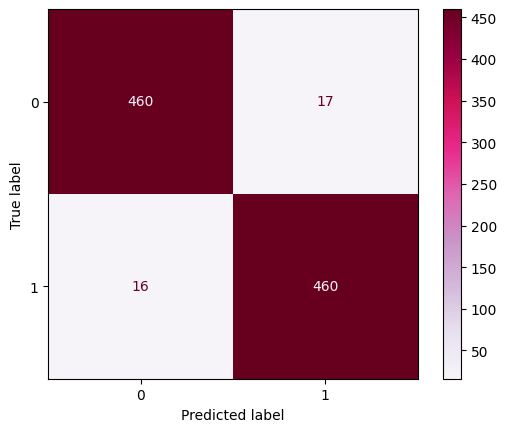

In [177]:
#Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='PuRd');

In [178]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       477
           1       0.96      0.97      0.97       476

    accuracy                           0.97       953
   macro avg       0.97      0.97      0.97       953
weighted avg       0.97      0.97      0.97       953



In [179]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [180]:
# Confusion matrix
ConfusionMatrix = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                columns=['Predicted 0','Predicted 1'],
                                index=['Actual 0','Actual 1'])
# Precision
print('Precision:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0]))

# Recall
print('Recall:', ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]))

# Accuracy
print('Accuracy:', (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1]) / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0] + ConfusionMatrix.iloc[0,1] + ConfusionMatrix.iloc[1,1]))


Precision: 0.9663865546218487
Recall: 0.5
Accuracy: 0.9653725078698846


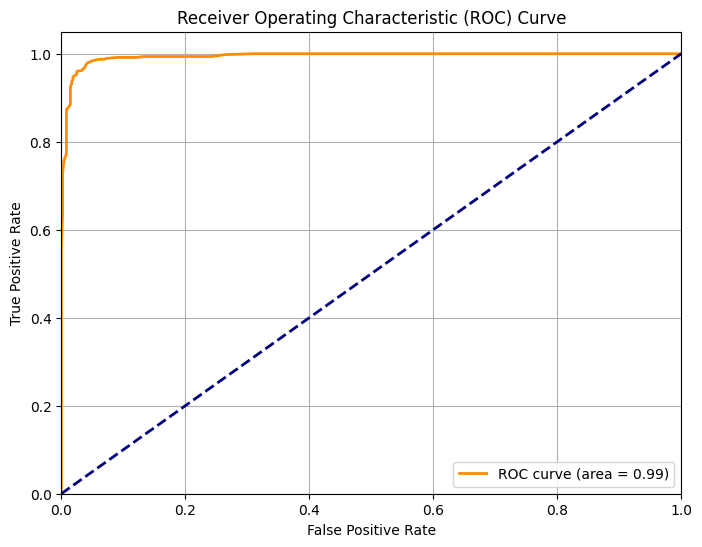

In [181]:
# prompt: display  ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [183]:
# prompt: F1 score

# F1 Score
precision = ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,0])
recall = ConfusionMatrix.iloc[0,0] / (ConfusionMatrix.iloc[0,0] + ConfusionMatrix.iloc[1,1])

# Check for potential division by zero if both precision and recall are zero
if precision + recall == 0:
  f1_score = 0.0
else:
  f1_score = 2 * (precision * recall) / (precision + recall)

print(f'F1 Score: {f1_score:.2f}')


F1 Score: 0.66


--- Test Set Performance ---


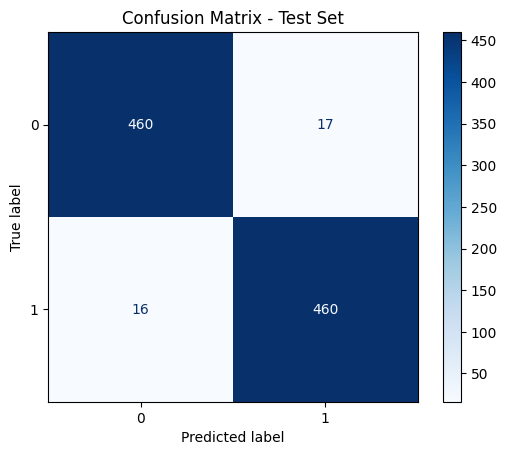


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       477
           1       0.96      0.97      0.97       476

    accuracy                           0.97       953
   macro avg       0.97      0.97      0.97       953
weighted avg       0.97      0.97      0.97       953

Accuracy (Test Set): 0.9654
------------------------------

--- Training Set Performance ---


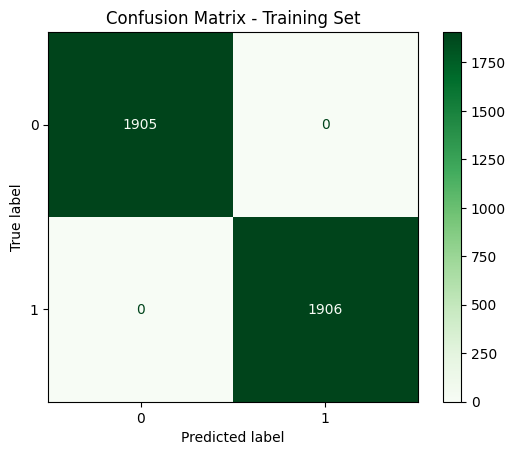


Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1905
           1       1.00      1.00      1.00      1906

    accuracy                           1.00      3811
   macro avg       1.00      1.00      1.00      3811
weighted avg       1.00      1.00      1.00      3811

Accuracy (Training Set): 1.0000
------------------------------

--- Comparison for Overfitting ---
Training Accuracy: 1.0000
Test Accuracy:     0.9654


In [184]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt


# --- 1. Performance on TEST SET (your existing code) ---
print("--- Test Set Performance ---")
y_pred_test = model.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)

# Displaying the confusion matrix for the test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_) # Or use [0, 1] if you know the class labels
disp_test.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()

# Calculate and print metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))
print(f"Accuracy (Test Set): {accuracy_test:.4f}")
print("-" * 30)


# --- 2. Performance on TRAINING SET ---
print("\n--- Training Set Performance ---")
y_pred_train = model.predict(X_train) # Use x_train here
cm_train = confusion_matrix(y_train, y_pred_train) # Use y_train here

# Displaying the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_) # Or use [0, 1]
disp_train.plot(cmap='Greens') # Use a different color map for clarity
plt.title("Confusion Matrix - Training Set")
plt.show()

# Calculate and print metrics for the training set
accuracy_train = accuracy_score(y_train, y_pred_train)
print("\nClassification Report (Training Set):")
print(classification_report(y_train, y_pred_train))
print(f"Accuracy (Training Set): {accuracy_train:.4f}")
print("-" * 30)


# --- 3. Compare and Interpret ---
print("\n--- Comparison for Overfitting ---")
print(f"Training Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy:     {accuracy_test:.4f}")


## 2- Using Cross Validation

In [188]:
del model

Performing 5-Fold Stratified Cross-Validation with Confusion Matrices and Metrics...



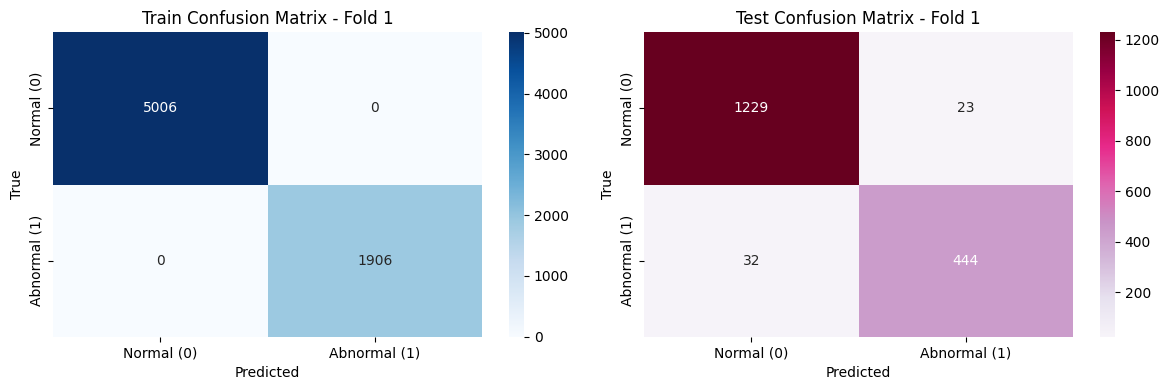

Fold 1:
Training Set Metrics:
  Accuracy: 1.0000
  Precision (class 1): 1.0000
  Recall (class 1): 1.0000
  F1-Score (class 1): 1.0000
  Confusion Matrix:
[[5006    0]
 [   0 1906]]
  Class distribution:
Abnormal
0    5006
1    1906
Name: count, dtype: int64

Test Set Metrics:
  Accuracy: 0.9682
  Precision (class 1): 0.9507
  Recall (class 1): 0.9328
  F1-Score (class 1): 0.9417
  Confusion Matrix:
[[1229   23]
 [  32  444]]
  Class distribution:
Abnormal
0    1252
1     476
Name: count, dtype: int64



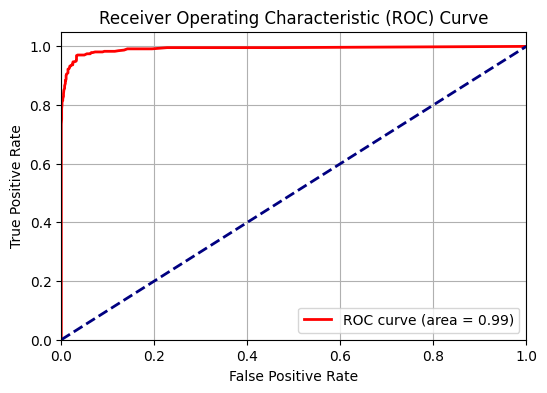

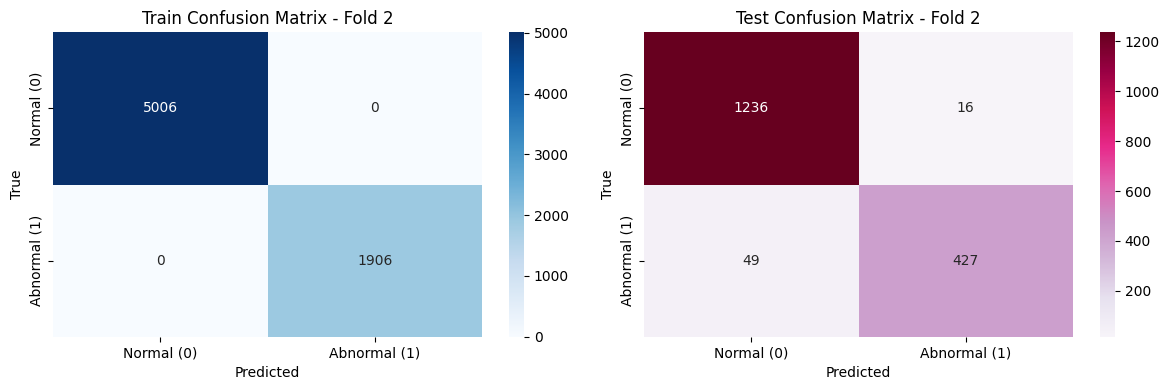

Fold 2:
Training Set Metrics:
  Accuracy: 1.0000
  Precision (class 1): 1.0000
  Recall (class 1): 1.0000
  F1-Score (class 1): 1.0000
  Confusion Matrix:
[[5006    0]
 [   0 1906]]
  Class distribution:
Abnormal
0    5006
1    1906
Name: count, dtype: int64

Test Set Metrics:
  Accuracy: 0.9624
  Precision (class 1): 0.9639
  Recall (class 1): 0.8971
  F1-Score (class 1): 0.9293
  Confusion Matrix:
[[1236   16]
 [  49  427]]
  Class distribution:
Abnormal
0    1252
1     476
Name: count, dtype: int64



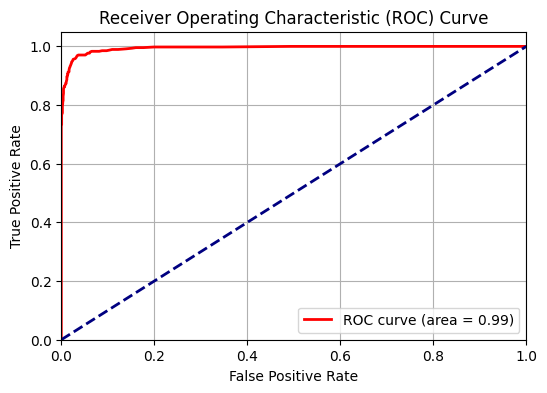

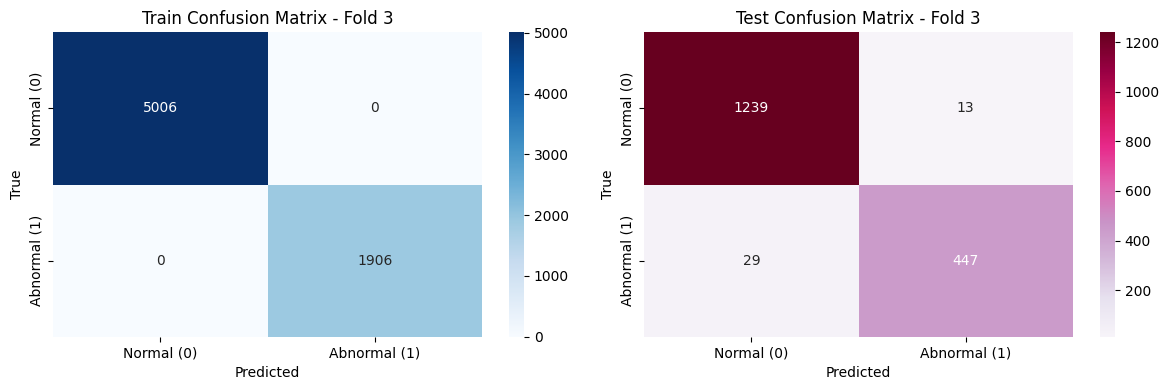

Fold 3:
Training Set Metrics:
  Accuracy: 1.0000
  Precision (class 1): 1.0000
  Recall (class 1): 1.0000
  F1-Score (class 1): 1.0000
  Confusion Matrix:
[[5006    0]
 [   0 1906]]
  Class distribution:
Abnormal
0    5006
1    1906
Name: count, dtype: int64

Test Set Metrics:
  Accuracy: 0.9757
  Precision (class 1): 0.9717
  Recall (class 1): 0.9391
  F1-Score (class 1): 0.9551
  Confusion Matrix:
[[1239   13]
 [  29  447]]
  Class distribution:
Abnormal
0    1252
1     476
Name: count, dtype: int64



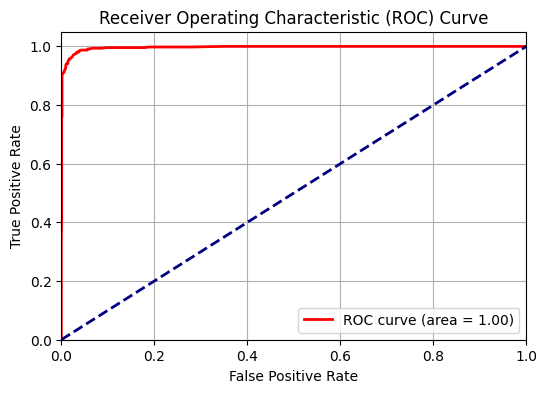

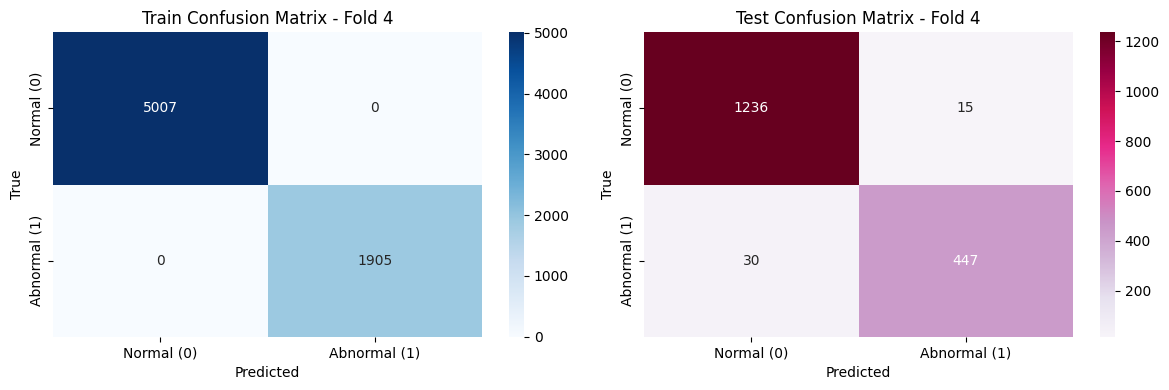

Fold 4:
Training Set Metrics:
  Accuracy: 1.0000
  Precision (class 1): 1.0000
  Recall (class 1): 1.0000
  F1-Score (class 1): 1.0000
  Confusion Matrix:
[[5007    0]
 [   0 1905]]
  Class distribution:
Abnormal
0    5007
1    1905
Name: count, dtype: int64

Test Set Metrics:
  Accuracy: 0.9740
  Precision (class 1): 0.9675
  Recall (class 1): 0.9371
  F1-Score (class 1): 0.9521
  Confusion Matrix:
[[1236   15]
 [  30  447]]
  Class distribution:
Abnormal
0    1251
1     477
Name: count, dtype: int64



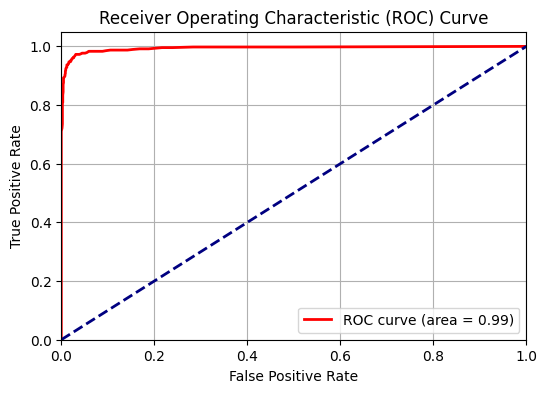

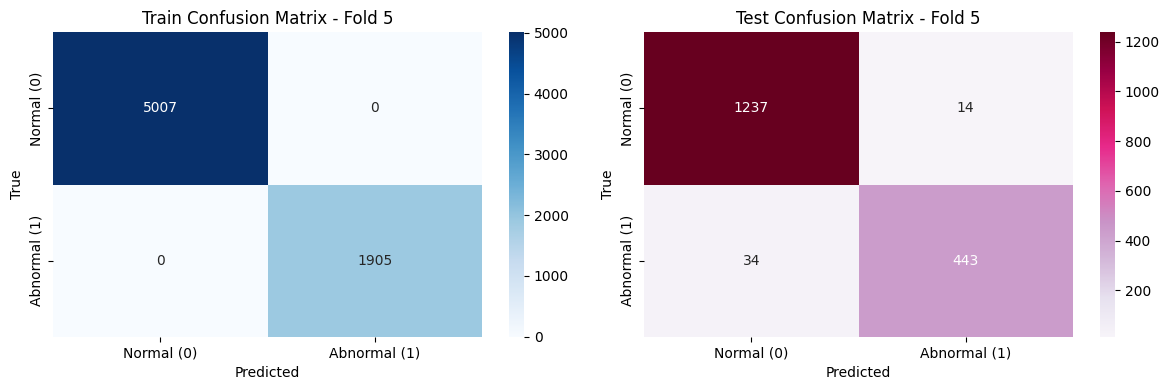

Fold 5:
Training Set Metrics:
  Accuracy: 1.0000
  Precision (class 1): 1.0000
  Recall (class 1): 1.0000
  F1-Score (class 1): 1.0000
  Confusion Matrix:
[[5007    0]
 [   0 1905]]
  Class distribution:
Abnormal
0    5007
1    1905
Name: count, dtype: int64

Test Set Metrics:
  Accuracy: 0.9722
  Precision (class 1): 0.9694
  Recall (class 1): 0.9287
  F1-Score (class 1): 0.9486
  Confusion Matrix:
[[1237   14]
 [  34  443]]
  Class distribution:
Abnormal
0    1251
1     477
Name: count, dtype: int64



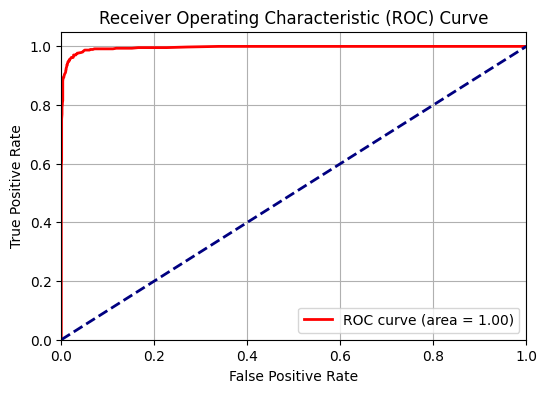

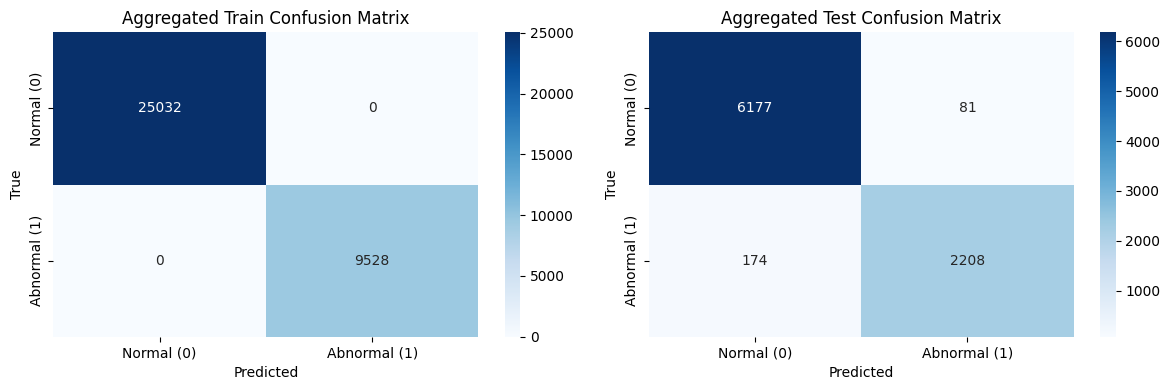

Aggregated Confusion Matrices Across All Folds:
Training Set:
 [[25032     0]
 [    0  9528]]
Test Set:
 [[6177   81]
 [ 174 2208]]

Average Metrics Across All Folds:
Training Set:
  Mean Accuracy: 1.0000 (±0.0000)
  Mean Precision (class 1): 1.0000 (±0.0000)
  Mean Recall (class 1): 1.0000 (±0.0000)
  Mean F1-Score (class 1): 1.0000 (±0.0000)

Test Set:
  Mean Accuracy: 0.9705 (±0.0048)
  Mean Precision (class 1): 0.9647 (±0.0074)
  Mean Recall (class 1): 0.9269 (±0.0154)
  Mean F1-Score (class 1): 0.9454 (±0.0092)


In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_windows is your DataFrame with features and target 'Abnormal'
X = df_windows.drop('Abnormal', axis=1)
y = df_windows['Abnormal']

# Optional: Scale features (kept as DataFrame to avoid feature name warnings)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Initialize StratifiedKFold with 5 folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize the model with class_weight for imbalance
cv_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Lists to store metrics for each fold (for both train and test sets)
train_accuracy_scores, test_accuracy_scores = [], []
train_precision_scores, test_precision_scores = [], []
train_recall_scores, test_recall_scores = [], []
train_f1_scores, test_f1_scores = [], []

# Store predictions and true labels across all folds for aggregated matrices
all_y_true_train, all_y_pred_train = [], []
all_y_true_test, all_y_pred_test = [], []

# Perform Stratified K-Fold Cross-Validation
print(f"Performing {n_splits}-Fold Stratified Cross-Validation with Confusion Matrices and Metrics...\n")
for fold, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
    # Split data into train and test for this fold
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    cv_model.fit(X_train, y_train)

    # Make predictions on both train and test sets
    y_pred_train = cv_model.predict(X_train)
    y_pred_test = cv_model.predict(X_test)

    # Store for aggregated matrices
    all_y_true_train.extend(y_train)
    all_y_pred_train.extend(y_pred_train)
    all_y_true_test.extend(y_test)
    all_y_pred_test.extend(y_pred_test)

    # Compute confusion matrices for train and test sets
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    # Compute metrics for train and test sets
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train, pos_label=1)
    train_recall = recall_score(y_train, y_pred_train, pos_label=1)
    train_f1 = f1_score(y_train, y_pred_train, pos_label=1)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test, pos_label=1)
    test_recall = recall_score(y_test, y_pred_test, pos_label=1)
    test_f1 = f1_score(y_test, y_pred_test, pos_label=1)

    # Store metrics
    train_accuracy_scores.append(train_accuracy)
    train_precision_scores.append(train_precision)
    train_recall_scores.append(train_recall)
    train_f1_scores.append(train_f1)

    test_accuracy_scores.append(test_accuracy)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_f1_scores.append(test_f1)

    # Plot confusion matrices for this fold (train and test)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Training set confusion matrix
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Normal (0)', 'Abnormal (1)'],
                yticklabels=['Normal (0)', 'Abnormal (1)'])
    axes[0].set_title(f'Train Confusion Matrix - Fold {fold}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Test set confusion matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='PuRd', ax=axes[1],
                xticklabels=['Normal (0)', 'Abnormal (1)'],
                yticklabels=['Normal (0)', 'Abnormal (1)'])
    axes[1].set_title(f'Test Confusion Matrix - Fold {fold}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # Print results for this fold
    print(f"Fold {fold}:")
    print("Training Set Metrics:")
    print(f"  Accuracy: {train_accuracy:.4f}")
    print(f"  Precision (class 1): {train_precision:.4f}")
    print(f"  Recall (class 1): {train_recall:.4f}")
    print(f"  F1-Score (class 1): {train_f1:.4f}")
    print(f"  Confusion Matrix:\n{cm_train}")
    print(f"  Class distribution:\n{y_train.value_counts()}\n")

    print("Test Set Metrics:")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  Precision (class 1): {test_precision:.4f}")
    print(f"  Recall (class 1): {test_recall:.4f}")
    print(f"  F1-Score (class 1): {test_f1:.4f}")
    print(f"  Confusion Matrix:\n{cm_test}")
    print(f"  Class distribution:\n{y_test.value_counts()}\n")
    # Get predicted probabilities for the positive class

    y_prob = cv_model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate Area Under the Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot aggregated confusion matrices across all folds (train and test)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Aggregated training set confusion matrix
aggregated_cm_train = confusion_matrix(all_y_true_train, all_y_pred_train)
sns.heatmap(aggregated_cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal (0)', 'Abnormal (1)'],
            yticklabels=['Normal (0)', 'Abnormal (1)'])
axes[0].set_title('Aggregated Train Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Aggregated test set confusion matrix
aggregated_cm_test = confusion_matrix(all_y_true_test, all_y_pred_test)
sns.heatmap(aggregated_cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal (0)', 'Abnormal (1)'],
            yticklabels=['Normal (0)', 'Abnormal (1)'])
axes[1].set_title('Aggregated Test Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Print aggregated confusion matrices
print("Aggregated Confusion Matrices Across All Folds:")
print("Training Set:\n", aggregated_cm_train)
print("Test Set:\n", aggregated_cm_test)

# Print average metrics across all folds for both train and test sets
print("\nAverage Metrics Across All Folds:")
print("Training Set:")
print(f"  Mean Accuracy: {np.mean(train_accuracy_scores):.4f} (±{np.std(train_accuracy_scores):.4f})")
print(f"  Mean Precision (class 1): {np.mean(train_precision_scores):.4f} (±{np.std(train_precision_scores):.4f})")
print(f"  Mean Recall (class 1): {np.mean(train_recall_scores):.4f} (±{np.std(train_recall_scores):.4f})")
print(f"  Mean F1-Score (class 1): {np.mean(train_f1_scores):.4f} (±{np.std(train_f1_scores):.4f})")

print("\nTest Set:")
print(f"  Mean Accuracy: {np.mean(test_accuracy_scores):.4f} (±{np.std(test_accuracy_scores):.4f})")
print(f"  Mean Precision (class 1): {np.mean(test_precision_scores):.4f} (±{np.std(test_precision_scores):.4f})")
print(f"  Mean Recall (class 1): {np.mean(test_recall_scores):.4f} (±{np.std(test_recall_scores):.4f})")
print(f"  Mean F1-Score (class 1): {np.mean(test_f1_scores):.4f} (±{np.std(test_f1_scores):.4f})")

# **Average Metrics Across All Folds:**
Training Set:
--

* Mean Accuracy: 1.0000 (±0.0000)

* Mean Precision (class 1): 1.0000 (±0.0000)

* Mean Recall (class 1): 1.0000 (±0.0000)

* Mean F1-Score (class 1): 1.0000 (±0.0000)

Test Set:
--

* Mean Accuracy: 0.9705 (±0.0048)

* Mean Precision (class 1): 0.9647 (±0.0074)

* Mean Recall (class 1): 0.9269 (±0.0154)

* Mean F1-Score (class 1): 0.9454 (±0.0092)

## Decision Tree

Decision Tree Accuracy: 0.94

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1251
           1       0.89      0.88      0.88       477

    accuracy                           0.94      1728
   macro avg       0.92      0.92      0.92      1728
weighted avg       0.94      0.94      0.94      1728


Decision Tree Confusion Matrix:


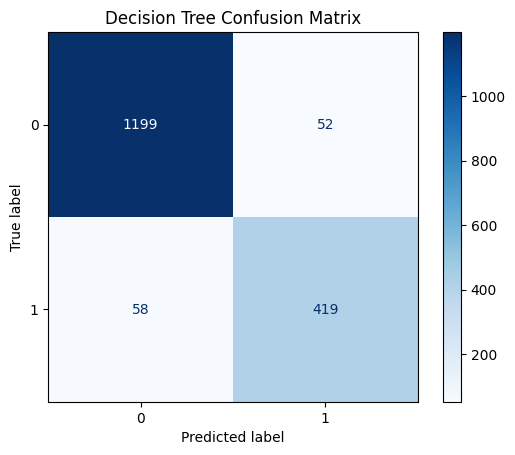

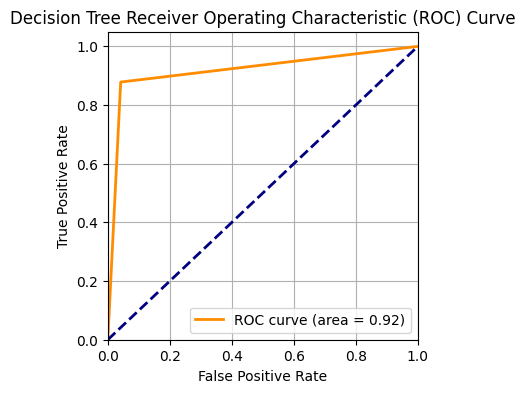

Decision Tree F1 Score: 0.83


In [196]:
# prompt: try with a decision tree model

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
# You can tune hyperparameters like max_depth, min_samples_split, min_samples_leaf
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Evaluate the model on the test set
dt_score = dt_model.score(X_test, y_test)
print(f"Decision Tree Accuracy: {dt_score:.2f}")

# Make predictions on the test set
y_pred_dt = dt_model.predict(X_test)

# Print classification report
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Plot confusion matrix
print("\nDecision Tree Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay(cm_dt).plot(cmap='Blues')
plt.title("Decision Tree Confusion Matrix")
plt.show()

# Calculate and plot ROC curve and AUC
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(4, 4))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Calculate F1 Score
# Check for potential division by zero if both precision and recall are zero
precision_dt = cm_dt[0,0] / (cm_dt[0,0] + cm_dt[1,0]) if (cm_dt[0,0] + cm_dt[1,0]) != 0 else 0
recall_dt = cm_dt[0,0] / (cm_dt[0,0] + cm_dt[1,1]) if (cm_dt[0,0] + cm_dt[1,1]) != 0 else 0


if precision_dt + recall_dt == 0:
  f1_score_dt = 0.0
else:
  f1_score_dt = 2 * (precision_dt * recall_dt) / (precision_dt + recall_dt)

print(f'Decision Tree F1 Score: {f1_score_dt:.2f}')
